# The role of topic choice in cross-partisan conversations

Code to produce analysis and figures

In [1]:
! pip install matplotlib
! pip install pandas
! pip install scikit-learn
! pip install seaborn
! pip install scipy
! pip install statsmodels
! pip install arviz
! pip install pymc


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.utils import resample
from scipy import stats
import matplotlib.gridspec as gridspec

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import json

# Enable math text rendering
plt.rc('text', usetex=False)
plt.rc('mathtext', fontset='stix')

In [3]:
# Import data
data = pd.read_csv("study_data.csv")

# Compute additional variables and scalings
data["trait_ratings_change_percent"] = data["trait_ratings_change"] * 100  # scale to percentage
data["pretest_normOverallAffect_scaled"] = data["pretest_normOverallAffect"] *100  # scale to 0-100 to match trait ratings
data["disagreement_scaled"] = data["disagreement"] / 6 # scale to 0-1
data["topic_contentiousness_scaled"] = data["topic_contentiousness"] / 3 # scale to 0-1
data["topic_polarization_scaled"] = data["topic_polarization"] / 1 # scale to 0-1 (already scaled this way)
data["topic_mean_identity_threat_scaled"] = data["topic_mean_identity_threat"] / 1 # scale to 0-1 (already scaled this way)

# Create a list that will hold the attriters
attritters = data.copy()
print(f'started with {len(data)} rows')

# Filter data
data = data[data["discussion_happened"] == True]  # only keep the data where the discussion happened
data = data[data["overfast_stages"] == 0]
print(f'filtered to {len(data)} rows with discussion happened and no overfast stages')

# Drop rows with missing values in predictors and outcomes
primary_DVs = ['outpartyTemp_change', 'trait_ratings_change']
data.dropna(subset=primary_DVs, inplace=True)
print(f'filtered to {len(data)} rows with no missing values in primary DVs')


# check that the standard deviation of the topic-level predictors is zero - ie, they all have the same value
assert(data.groupby("discussionTopic")["topic_polarization"].std().max() == 0 and 
       data.groupby("discussionTopic")["topic_contentiousness"].std().max() == 0 and 
       data.groupby("discussionTopic")["topic_mean_identity_threat"].std().max() == 0)

# check that the primary IVs have no missing values
assert(data['topic_polarization'].isna().sum() == 0 and
       data['topic_contentiousness'].isna().sum() == 0 and
       data['topic_mean_identity_threat'].isna().sum() == 0 and 
       data['disagreement'].isna().sum() == 0)

# check that the primary DVs have no missing values
assert(data['outpartyTemp_change'].isna().sum() == 0 and
       data['trait_ratings_change'].isna().sum() == 0)

# Generate a color palette based on the number of unique topics
# Infer the number of unique discussion topics
unique_topics = data['discussionTopic'].unique()
num_topics = len(unique_topics)
colors = sns.color_palette("tab10", num_topics)

# Create a color mapping based on the topics and the generated colors
color_mapping = {topic: color for topic, color in zip(unique_topics, colors)}

# Assign colors based on the discussion topic
data['color'] = data['discussionTopic'].map(color_mapping)

# remove all completing participants from the list of attriters
attritters = attritters[~attritters["sampleId"].isin(data["sampleId"])]

# Check the data
data.groupby("wave")["outpartyTemp_change"].count()

started with 1031 rows
filtered to 816 rows with discussion happened and no overfast stages
filtered to 805 rows with no missing values in primary DVs


/var/folders/2l/3kmvzs0s1sggnw_9sl0ls8080000gn/T/ipykernel_71154/2421175773.py:2: DtypeWarning: Columns (28,53,55,576) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("study_data.csv")


wave
1    396
2    409
Name: outpartyTemp_change, dtype: int64

# General effectiveness of all discussion topics

In [4]:
print(f'Mean outpartyTemp_change: {data["outpartyTemp_change"].mean():.1f}')
print(f'Starting outpartyTemp mean: {data["pretest_outpartyTemp"].mean():.1f}')
print(f'Percent of original outpartyTemp change: {100*data["outpartyTemp_change"].mean() / data["pretest_outpartyTemp"].mean():.1f}')

print()

print(f'Mean Trait Ratings Change: {data["trait_ratings_change_percent"].mean():.1f}')
print(f'Starting Trait Ratings mean: {data["pretest_normOverallAffect"].mean()*100:.1f}')
print(f'Percent of original Trait Ratings change: {data["trait_ratings_change_percent"].mean() / data["pretest_normOverallAffect"].mean():.1f}')

Mean outpartyTemp_change: 8.9
Starting outpartyTemp mean: 35.9
Percent of original outpartyTemp change: 24.9

Mean Trait Ratings Change: 13.3
Starting Trait Ratings mean: 40.0
Percent of original Trait Ratings change: 33.2


### Figure 1
This bar chart of topic mean effects allows for comparison between the effectiveness of different topics in the study.

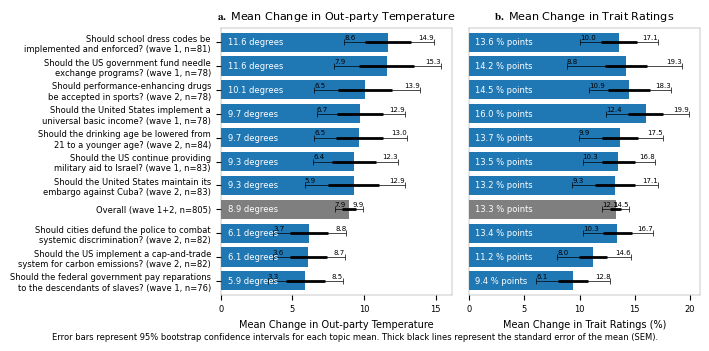

In [5]:
N_BOOTSTRAPS = 100000

# Function to wrap text into two lines
def wrap_text_two_lines(text):
    """Wraps text into two lines of approximately equal length.

    Args:
        text: The string to wrap.

    Returns:
        A string with the text wrapped into two lines, or the original string 
        if it's too short to wrap.
    """
    words = text.split()
    if len(words) <= 1:
        return text
    
    middle_index = len(words) // 2
    line1 = " ".join(words[:middle_index])
    line2 = " ".join(words[middle_index:])

    # Adjust the split if it creates very uneven lines
    if abs(len(line1) - len(line2)) > 5: # Adjust threshold as needed
        middle_index = find_optimal_split(words)
        line1 = " ".join(words[:middle_index])
        line2 = " ".join(words[middle_index:])
        
    return line1 + "\n" + line2

# Function to split the text into two lines of approximately equal length
def find_optimal_split(words):
  """Finds the best index to split a list of words for near-equal length lines."""
  min_diff = float('inf')
  optimal_index = len(words) // 2
  for i in range(1, len(words)):
    diff = abs(len(" ".join(words[:i])) - len(" ".join(words[i:])))
    if diff < min_diff:
      min_diff = diff
      optimal_index = i
  return optimal_index


# Function to calculate bootstrap CI
def bootstrap_ci(series, n_bootstraps=N_BOOTSTRAPS, ci=95):
    bootstrapped_means = []
    for _ in range(n_bootstraps):
        sample = resample(series)
        bootstrapped_means.append(sample.mean())
    lower_bound = np.percentile(bootstrapped_means, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_means, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound


# Prepare to store bootstrap CIs for outpartyTemp_change
topic_means_temp = data.groupby('discussionTopic')['outpartyTemp_change'].mean()
topic_counts_temp = data.groupby('discussionTopic').size()

# Calculate bootstrap CIs for each topic for outpartyTemp_change
topic_cis_temp = data.groupby('discussionTopic')['outpartyTemp_change'].apply(bootstrap_ci)

# Calculate SEM for each topic for outpartyTemp_change
topic_se_temp = data.groupby('discussionTopic')['outpartyTemp_change'].apply(lambda x: stats.sem(x, nan_policy='omit'))

# Add overall mean, bootstrap CI, and SEM for outpartyTemp_change
overall_mean_temp = data['outpartyTemp_change'].mean()
overall_ci_temp = bootstrap_ci(data['outpartyTemp_change'])
overall_se_temp = stats.sem(data['outpartyTemp_change'], nan_policy='omit')
topic_means_temp['Overall'] = overall_mean_temp
topic_cis_temp['Overall'] = overall_ci_temp
topic_se_temp['Overall'] = overall_se_temp
topic_counts_temp['Overall'] = len(data)

# Sort by the mean effect, including the overall mean for outpartyTemp_change
sorted_means_temp = topic_means_temp.sort_values()
sorted_cis_temp = topic_cis_temp.reindex(sorted_means_temp.index)
sorted_se_temp = topic_se_temp.reindex(sorted_means_temp.index)
sorted_counts_temp = topic_counts_temp.reindex(sorted_means_temp.index)

# Prepare to store bootstrap CIs for trait_ratings_change_percent
topic_means_trait = data.groupby('discussionTopic')['trait_ratings_change_percent'].mean()
topic_counts_trait = data.groupby('discussionTopic').size()
topic_cis_trait = data.groupby('discussionTopic')['trait_ratings_change_percent'].apply(bootstrap_ci)

# Calculate overall mean and bootstrap CI for trait_ratings_change_percent
overall_mean_trait = data['trait_ratings_change_percent'].mean()
overall_ci_trait = bootstrap_ci(data['trait_ratings_change_percent'])
topic_means_trait['Overall'] = overall_mean_trait
topic_cis_trait['Overall'] = overall_ci_trait
topic_counts_trait['Overall'] = len(data)

# Sort by the mean effect, including the overall mean for trait_ratings_change_percent
sorted_means_trait = topic_means_trait.reindex(sorted_means_temp.index)
sorted_cis_trait = topic_cis_trait.reindex(sorted_means_temp.index)
sorted_counts_trait = topic_counts_trait.reindex(sorted_means_temp.index)

# Create the plot with two subplots arranged side by side
fig = plt.figure(figsize=(7.2, 3.5))  # Set figure size to 7.2 inches wide
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharey=ax1)

# Plot the individual topic means for outpartyTemp_change in blue, and overall in gray
bars_temp = ax1.barh(sorted_means_temp.index, sorted_means_temp.values, 
                     xerr=[(sorted_means_temp - sorted_cis_temp.str[0]), (sorted_cis_temp.str[1] - sorted_means_temp)],
                     capsize=2.5, color=['tab:blue' if topic != 'Overall' else 'tab:gray' for topic in sorted_means_temp.index], error_kw={'elinewidth': .5, 'capthick': .5})

# Add SEM as a thicker black line on top of the error bars for outpartyTemp_change
for i, bar in enumerate(bars_temp):
    topic_name = sorted_means_temp.index[i]
    sem = sorted_se_temp[topic_name]
    ax1.errorbar(x=sorted_means_temp[topic_name], y=bar.get_y() + bar.get_height() / 2, 
                 xerr=sem, fmt='none', ecolor='black', elinewidth=2, capsize=0)

# Annotate each bar with its value and CI for outpartyTemp_change
for i, bar in enumerate(bars_temp):
    # Bar mean value annotation
    ax1.text(0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.1f} degrees', 
             va='center', ha='left', color='white', fontsize=6)
    
    # Get the topic name for this bar based on the index
    topic_name = sorted_means_temp.index[i]
    
    # CI annotations
    left_x, right_x = sorted_cis_temp[topic_name]
    ax1.text(left_x, bar.get_y() + bar.get_height() / 2 + 0.2, f'{left_x:.1f}', 
             va='center', ha='left', color='black', fontsize=5)
    ax1.text(right_x, bar.get_y() + bar.get_height() / 2 + 0.2, f'{right_x:.1f}', 
             va='center', ha='right', color='black', fontsize=5)

# Plot the individual topic means for trait_ratings_change_percent in red, and overall in gray
bars_trait = ax2.barh(sorted_means_trait.index, sorted_means_trait.values, 
                      xerr=[(sorted_means_trait - sorted_cis_trait.str[0]), (sorted_cis_trait.str[1] - sorted_means_trait)],
                      capsize=2.5, color=['tab:blue' if topic != 'Overall' else 'tab:gray' for topic in sorted_means_trait.index], error_kw={'elinewidth': .5, 'capthick': .5})

# Add SEM as a thicker black line on top of the error bars for trait_ratings_change_percent
for i, bar in enumerate(bars_trait):
    topic_name = sorted_means_trait.index[i]
    sem = sorted_se_temp[topic_name]
    ax2.errorbar(x=sorted_means_trait[topic_name], y=bar.get_y() + bar.get_height() / 2, 
                 xerr=sem, fmt='none', ecolor='black', elinewidth=2, capsize=0)

# Annotate each bar with its value and CI for trait_ratings_change_percent
for i, bar in enumerate(bars_trait):
    # Bar mean value annotation
    ax2.text(0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.1f} % points', 
             va='center', ha='left', color='white', fontsize=6)
    
    # CI annotations
    left_x, right_x = sorted_cis_trait[sorted_means_trait.index[i]]
    ax2.text(left_x, bar.get_y() + bar.get_height() / 2 + 0.2, f'{left_x:.1f}', 
             va='center', ha='left', color='black', fontsize=5)
    ax2.text(right_x, bar.get_y() + bar.get_height() / 2 + 0.2, f'{right_x:.1f}', 
             va='center', ha='right', color='black', fontsize=5)

# Customize the y-tick labels to include the full question text and the number of data points for each topic
question_texts = data.groupby('discussionTopic')['question'].first()
extended_texts = {topic: f"{question_texts[topic] if topic != 'Overall' else 'Overall'} (wave {data[data['discussionTopic']==topic]['wave'].iloc[0] if topic != 'Overall' else '1+2'}, n={sorted_counts_temp[topic]})"  for topic in sorted_means_temp.index } 
wrapped_texts = {topic: wrap_text_two_lines(extended_texts[topic]) if topic != 'Overall' else extended_texts[topic] for topic in sorted_means_temp.index}
ax1.set_yticks(range(len(sorted_means_temp.index)))
ax1.set_yticklabels([wrapped_texts[topic] for topic in sorted_means_temp.index], fontsize=6)

# Turn off y-ticks and y-tick labels for the right-hand plot
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Customize the plot
ax1.set_title(r'$\mathbf{a.}$ Mean Change in Out-party Temperature', fontsize=8)
ax1.set_xlabel('Mean Change in Out-party Temperature', fontsize=7)
ax2.set_title(r'$\mathbf{b.}$ Mean Change in Trait Ratings', fontsize=8)
ax2.set_xlabel('Mean Change in Trait Ratings (%)', fontsize=7)


ax1.set_xticks(np.arange(0,16,5))
ax1.set_xticklabels(np.arange(0,16,5), fontsize=6)
ax2.set_xticks(np.arange(0,21,5))
ax2.set_xticklabels(np.arange(0,21,5), fontsize=6)
ax1.set_ylim(-.6,10.6)

# Add a caption below the plot to explain the error bars
fig.text(0.5, 0.01, 'Error bars represent 95% bootstrap confidence intervals for each topic mean. Thick black lines represent the standard error of the mean (SEM).', ha='center', va='bottom', fontsize=6)

# Customize the spines (the boxes around the figure)
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.3)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('fig_topic_effects.pdf', format='pdf')

# Substantial differences between topics

In [6]:
topic_means = data.groupby('discussionTopic')[['outpartyTemp_change', 'trait_ratings_change_percent']].mean()
print(f"Ratio of Best to Worst Topic Means for Out-party Temperature Change: {topic_means['outpartyTemp_change'].max() / topic_means['outpartyTemp_change'].min():.1f}")
print(f"Ratio of Best to Worst Topic Means for Trait Ratings Change: {topic_means['trait_ratings_change_percent'].max() / topic_means['trait_ratings_change_percent'].min():.1f}")
print(f"Difference between Best and Worst Topic Means for Out-party Temperature Change: {topic_means['outpartyTemp_change'].max() - topic_means['outpartyTemp_change'].min():.1f}")
print(f"Correlation between Out-party Temperature Change and Trait Ratings Change: {topic_means['outpartyTemp_change'].corr(topic_means['trait_ratings_change_percent']):.2f}, p-value: {stats.pearsonr(topic_means['outpartyTemp_change'], topic_means['trait_ratings_change_percent'])[1]:.3f}")

Ratio of Best to Worst Topic Means for Out-party Temperature Change: 2.0
Ratio of Best to Worst Topic Means for Trait Ratings Change: 1.7
Difference between Best and Worst Topic Means for Out-party Temperature Change: 5.7
Correlation between Out-party Temperature Change and Trait Ratings Change: 0.69, p-value: 0.026


In [7]:
print(f"Median Out-party Temperature Change: {topic_means['outpartyTemp_change'].median():.1f}")
print(f"Median Trait Ratings Change: {topic_means['trait_ratings_change_percent'].median():.1f}")
print(f"Topics below median Out-party Temperature Change: {topic_means[topic_means['outpartyTemp_change'] < topic_means['outpartyTemp_change'].median()].index.tolist()}")
print(f"Topics below median Trait Ratings Change: {topic_means[topic_means['trait_ratings_change_percent'] < topic_means['trait_ratings_change_percent'].median()].index.tolist()}")

Median Out-party Temperature Change: 9.5
Median Trait Ratings Change: 13.5
Topics below median Out-party Temperature Change: ['capAndTrade', 'cubaEmbargo', 'israelAid', 'policeDefundingDiscrimination', 'slaveReparations']
Topics below median Trait Ratings Change: ['capAndTrade', 'cubaEmbargo', 'israelAid', 'policeDefundingDiscrimination', 'slaveReparations']


# Primary predictors do not show expected effects

### Multivariate OLS regression

In [8]:
import statsmodels.api as sm

IVs = {
    "disagreement_scaled": "Dyadic Disagreement",
    "topic_polarization_scaled": "Topic Partisanship",
    "topic_contentiousness_scaled": "Topic Contentiousness",
    "topic_mean_identity_threat_scaled": "Topic Identity Threat",
}

DVs = {
    "outpartyTemp_change": {
        "label": "Feeling Thermometer Change",
        "range": (-40, 60)
    },
    "trait_ratings_change_percent": {
        "label": "Trait Ratings Change",
        "range": (-40, 60)
    }
}

waves = [
    {
        "number": 1,
        "label": "Wave 1"
    },
    {
        "number": 2,
        "label": "Wave 2 (Preregistered)",
    }
]

def run_regression(data, waves, IVs, DV, correct_pvals=False):
    """Run regression for a set of waves, IVs, and DV."""
    
    # Prepare the data
    X = data[data["wave"].apply(lambda x: x in waves)][IVs.keys()]
    y = data[DV].loc[X.index]

    # Add a constant for the intercept
    X = sm.add_constant(X)
        
    # Run the regression after all variables have been processed
    model = sm.OLS(y, X).fit()
    # Drop the constant ('const') from the coefficients and p-values
    coeffs = model.params.drop("const", errors="ignore")
    pvals = model.pvalues.drop("const", errors="ignore")

    if correct_pvals:
        corrected = sm.stats.multipletests(pvals, method="fdr_bh")[1]
        pvals = pd.Series(corrected, index=pvals.index)

    return coeffs, pvals


table_1_data = pd.DataFrame()
for wave in waves:
    for dv in DVs:
        coeffs, pvals = run_regression(data, [wave["number"]], IVs, dv)
        df = pd.DataFrame()
        df['IV'] = coeffs.index
        df['wave'] = wave["label"]
        df['DV'] = DVs[dv]["label"]
        df['coeff'] = coeffs.values
        df['pval'] = pvals.values
        
        table_1_data = pd.concat([table_1_data, df], axis=0)


table_1_data

,IV,wave,DV,coeff,pval
0,disagreement_scaled,Wave 1,Feeling Thermometer Change,1.121891,0.611372
1,topic_polarization_scaled,Wave 1,Feeling Thermometer Change,1.918168,0.746521
2,topic_contentiousness_scaled,Wave 1,Feeling Thermometer Change,-39.342471,0.257829
3,topic_mean_identity_threat_scaled,Wave 1,Feeling Thermometer Change,-6.044200,0.660568
0,disagreement_scaled,Wave 1,Trait Ratings Change,0.431326,0.875564
1,topic_polarization_scaled,Wave 1,Trait Ratings Change,2.174586,0.768990
2,topic_contentiousness_scaled,Wave 1,Trait Ratings Change,-19.507372,0.652721
3,topic_mean_identity_threat_scaled,Wave 1,Trait Ratings Change,-2.134298,0.901082
0,disagreement_scaled,Wave 2 (Preregistered),Feeling Thermometer Change,-2.206943,0.322223
1,topic_polarization_scaled,Wave 2 (Preregistered),Feeling Thermometer Change,-4.971207,0.398024


In [9]:
# Define the desired orders.
wave_order = ["Wave 1", "Wave 2 (Preregistered)"]
dv_order = ["Feeling Thermometer Change", "Trait Ratings Change"]
iv_order = list(IVs.keys())  

# Build the table body: one row per predictor.
table_rows = []

for iv in iv_order:
    # First column: human-readable predictor label in bold.
    row = [r"\textbf{" + IVs[iv] + r"}"]
    # For each DV (in the desired order) and each wave (in the desired order):
    for dv in dv_order:
        for wave in wave_order:
            # Filter table_1_data for the matching IV, DV, and wave.
            cell_df = table_1_data[
                (table_1_data["IV"] == iv) &
                (table_1_data["DV"] == dv) &
                (table_1_data["wave"] == wave)
            ]
            if cell_df.empty:
                cell = "—"
            else:
                coeff = cell_df["coeff"].iloc[0]
                pval = cell_df["pval"].iloc[0]
                cell = r"\makecell{" + f"{coeff:.3f}" + r" \\ (" + f"{pval:.3f}" + r")}"
            row.append(cell)
    table_rows.append(row)

# Build the nested header manually.
nested_header = r"""\begin{tabular}{lcccc}
\hline
\multirow{2}{*}{~} & \multicolumn{2}{c}{\textbf{Feeling Thermometer}} & \multicolumn{2}{c}{\textbf{Trait Ratings}} \\
 & Wave 1 & \makecell{Wave 2 \\ (preregistered)} & Wave 1 & \makecell{Wave 2 \\ (preregistered)} \\
\hline
"""

footer = r"""\hline

 \multicolumn{3}{l}{\footnotesize Multiple regression coefficients (uncorrected p-values)}\\
 \multicolumn{3}{l}{\footnotesize Coefficients standardized to the theoretical range of each predictor)}\\
 \hline
\end{tabular}
"""

# Assemble the table body by joining rows.
body_lines = []
for row in table_rows:
    body_lines.append(" & ".join(row) + r" \\")
body = "\n".join(body_lines)

# Combine header, body, and footer.
latex_table = nested_header + "\n" + body + "\n" + footer

# Write the final LaTeX table to a file.
with open("table_primary_predictors.tex", "w") as f:
    f.write(latex_table)

print(latex_table)

\begin{tabular}{lcccc}
\hline
\multirow{2}{*}{~} & \multicolumn{2}{c}{\textbf{Feeling Thermometer}} & \multicolumn{2}{c}{\textbf{Trait Ratings}} \\
 & Wave 1 & \makecell{Wave 2 \\ (preregistered)} & Wave 1 & \makecell{Wave 2 \\ (preregistered)} \\
\hline

\textbf{Dyadic Disagreement} & \makecell{1.122 \\ (0.611)} & \makecell{-2.207 \\ (0.322)} & \makecell{0.431 \\ (0.876)} & \makecell{-0.933 \\ (0.716)} \\
\textbf{Topic Partisanship} & \makecell{1.918 \\ (0.747)} & \makecell{-4.971 \\ (0.398)} & \makecell{2.175 \\ (0.769)} & \makecell{-6.454 \\ (0.340)} \\
\textbf{Topic Contentiousness} & \makecell{-39.342 \\ (0.258)} & \makecell{9.574 \\ (0.683)} & \makecell{-19.507 \\ (0.653)} & \makecell{-6.076 \\ (0.821)} \\
\textbf{Topic Identity Threat} & \makecell{-6.044 \\ (0.661)} & \makecell{-16.041 \\ (0.458)} & \makecell{-2.134 \\ (0.901)} & \makecell{8.631 \\ (0.729)} \\
\hline

 \multicolumn{3}{l}{\footnotesize Multiple regression coefficients (uncorrected p-values)}\\
 \multicolumn{3}{l}

### Range of IVs

In [10]:
# range of dataset independent variables
print(f"Range of variation in:")
print(f"  - disagreement: {data['disagreement_scaled'].min()} to {data['disagreement_scaled'].max()}")
print(f"  - topic_polarization: {data['topic_polarization_scaled'].min()} to {data['topic_polarization_scaled'].max()}")
print(f"  - topic_contentiousness: {data['topic_contentiousness_scaled'].min()} to {data['topic_contentiousness_scaled'].max()}")
print(f"  - topic_mean_identity_threat: {data['topic_mean_identity_threat_scaled'].min()} to {data['topic_mean_identity_threat_scaled'].max()}")

Range of variation in:
  - disagreement: 0.0 to 1.0
  - topic_polarization: 0.0311807201539533 to 0.5394392210609176
  - topic_contentiousness: 0.48490093976527504 to 0.7474325005740501
  - topic_mean_identity_threat: 0.1044520547945205 to 0.3732876712328767


### OLS R-squared for predictors

In [11]:
r2_table = pd.DataFrame(index = ["Feeling Thermometers", "Trait Ratings"])

# Topic Features
topic_features_feeling_thermometer = smf.ols('outpartyTemp_change ~ topic_polarization + topic_contentiousness + topic_mean_identity_threat', data=data).fit()
topic_features_model_trait_ratings = smf.ols('trait_ratings_change_percent ~ topic_polarization + topic_contentiousness + topic_mean_identity_threat', data=data).fit()

r2_table["Topic Features"] = [topic_features_feeling_thermometer.rsquared, topic_features_model_trait_ratings.rsquared]

# Topic Features + Disagreement
topic_features_disagreement_feeling_thermometer = smf.ols('outpartyTemp_change ~ topic_polarization + topic_contentiousness + topic_mean_identity_threat + disagreement', data=data).fit()
topic_features_disagreement_trait_ratings = smf.ols('trait_ratings_change_percent ~ topic_polarization + topic_contentiousness + topic_mean_identity_threat + disagreement', data=data).fit()

r2_table["Topic Features + Disagreement"] = [topic_features_disagreement_feeling_thermometer.rsquared, topic_features_disagreement_trait_ratings.rsquared]

r2_table


,Topic Features,Topic Features + Disagreement
Feeling Thermometers,0.011276,0.011421
Trait Ratings,0.001205,0.001226


### Simple OLS Regressions

In [12]:
# Define a helper function to run a univariate regression on one predictor
def run_univariate_regression(data, predictor, DV):
    # Drop missing values for the predictor and DV
    df = data[[predictor, DV]].dropna()
    X = sm.add_constant(df[predictor])
    y = df[DV]
    model = sm.OLS(y, X).fit()
    
    # Extract parameters
    intercept = model.params['const']
    slope = model.params[predictor]
    pval_intercept = model.pvalues['const']
    pval_slope = model.pvalues[predictor]
    
    # Confidence intervals
    ci = model.conf_int()
    intercept_ci_lower, intercept_ci_upper = ci.loc['const']
    slope_ci_lower, slope_ci_upper = ci.loc[predictor]
    
    # Extract covariance matrix and get variances and covariance
    cov_matrix = model.cov_params()
    var_intercept = cov_matrix.loc['const', 'const']
    var_slope = cov_matrix.loc[predictor, predictor]
    cov_intercept_slope = cov_matrix.loc['const', predictor]
    
    return (slope, pval_slope, slope_ci_lower, slope_ci_upper,
            intercept, pval_intercept, intercept_ci_lower, intercept_ci_upper,
            var_slope, var_intercept, cov_intercept_slope)

# Collect regression results in a list
results_list = []

for dv_key, dv_info in DVs.items():
    for iv_key, iv_label in IVs.items():
        # If your IVs are already scaled, no normalization is needed.
        (slope, pval_slope, slope_ci_lower, slope_ci_upper,
         intercept, pval_intercept, intercept_ci_lower, intercept_ci_upper,
         var_slope, var_intercept, cov_intercept_slope) = run_univariate_regression(data, iv_key, dv_key)
        results_list.append({
            "IV": iv_key,
            "IV_label": iv_label,
            "DV": dv_info["label"],
            "slope": slope,
            "slope_ci_lower": slope_ci_lower,
            "slope_ci_upper": slope_ci_upper,
            "slope_pval": pval_slope,
            "intercept": intercept,
            "intercept_ci_lower": intercept_ci_lower,
            "intercept_ci_upper": intercept_ci_upper,
            "intercept_pval": pval_intercept,
            "var_slope": var_slope,
            "var_intercept": var_intercept,
            "cov_intercept_slope": cov_intercept_slope
        })

# Create a DataFrame with the results
univariate_regressions_figure_df = pd.DataFrame(results_list)

# Apply multiple comparisons correction on all slope p-values together
corrected_slope = multipletests(univariate_regressions_figure_df["slope_pval"], method="fdr_bh")[1]
univariate_regressions_figure_df["slope_pval_corrected"] = corrected_slope

# Optionally, also correct intercept p-values
corrected_intercept = multipletests(univariate_regressions_figure_df["intercept_pval"], method="fdr_bh")[1]
univariate_regressions_figure_df["intercept_pval_corrected"] = corrected_intercept

# Optional: sort the results for clarity
univariate_regressions_figure_df = univariate_regressions_figure_df.sort_values(by=["DV", "IV"])

univariate_regressions_figure_df.head()

,IV,IV_label,DV,slope,slope_ci_lower,slope_ci_upper,slope_pval,intercept,intercept_ci_lower,intercept_ci_upper,intercept_pval,var_slope,var_intercept,cov_intercept_slope,slope_pval_corrected,intercept_pval_corrected
0,disagreement_scaled,Dyadic Disagreement,Feeling Thermometer Change,-0.518261,-3.607720,2.571199,0.742028,9.183635,7.390818,10.976452,1.749065e-22,2.477186,0.834191,-1.192434,0.926669,3.498129e-22
2,topic_contentiousness_scaled,Topic Contentiousness,Feeling Thermometer Change,-2.429833,-14.154439,9.294774,0.684263,10.469485,2.993778,17.945192,6.111818e-03,35.677151,14.504348,-22.543104,0.926669,6.111818e-03
3,topic_mean_identity_threat_scaled,Topic Identity Threat,Feeling Thermometer Change,-10.545396,-20.847903,-0.242889,0.044850,11.381004,8.790236,13.971773,3.452389e-17,27.547327,1.742011,-6.391793,0.358801,4.603186e-17
1,topic_polarization_scaled,Topic Partisanship,Feeling Thermometer Change,-4.027925,-9.402103,1.346254,0.141628,10.175883,8.240741,12.111025,1.537770e-23,7.495797,0.971895,-2.310791,0.566513,4.100721e-23
4,disagreement_scaled,Dyadic Disagreement,Trait Ratings Change,-0.237624,-3.909832,3.434583,0.898958,13.380471,11.249485,15.511458,4.306324e-32,3.499839,1.178569,-1.684705,0.926669,3.445059e-31


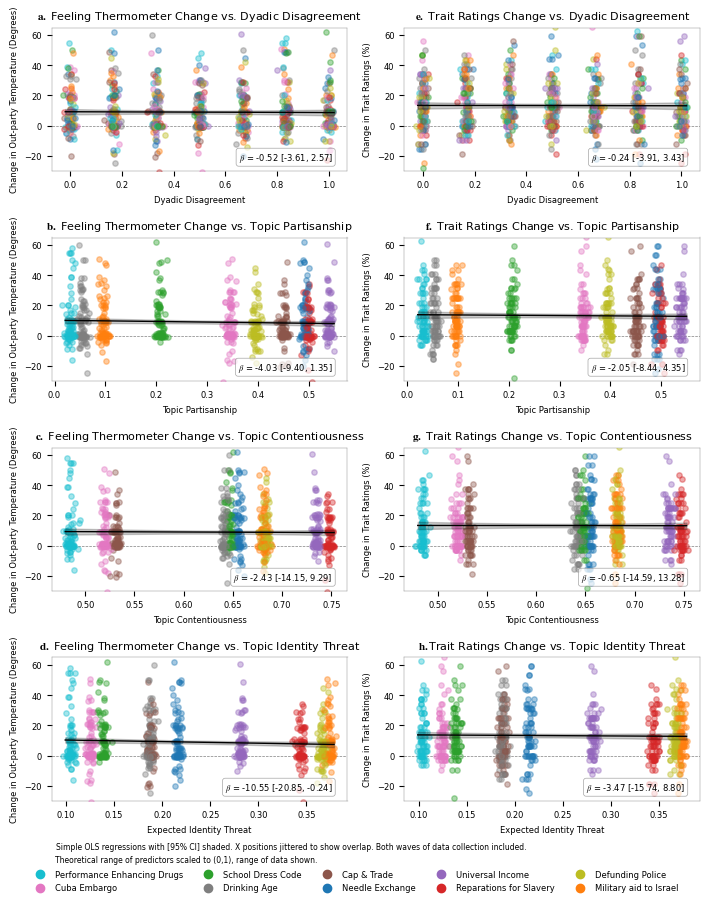

In [13]:
def plot_regressions(data, IV, IV_description,
                     DV, DV_label, DV_description, summary_df, 
                     annotate_overall_on_figure=True, 
                     jitter=True, ax=None):
    """
    Plot raw data (with jitter and per-topic coloring) and overlay the overall LS regression 
    (with intercept and slope) from a precomputed summary dataframe.
    
    Parameters:
      data: Raw data DataFrame (must include columns: IV, DV, discussionTopic, and 'color')
      IV: column name for independent variable (e.g., 'disagreement_scaled')
      IV_description: Description for x-axis.
      DV: column name for dependent variable.
      DV_label: Human-readable label for DV.
      DV_description: Description for y-axis.
      summary_df: DataFrame with regression summary including intercept, slope, their CIs, variances, and covariance.
      annotate_overall_on_figure: If True, an inset text box with regression summary is added.
      jitter: If True, add slight random noise to x positions so overlapping points can be seen.
      ax: matplotlib Axes object; if None, the current axes is used.
    """
    if ax is None:
        ax = plt.gca()
    
    # Determine x-axis limits from the data (drop missing values first)
    valid_data = data.dropna(subset=[DV, IV])
    data_min = valid_data[IV].min()
    data_max = valid_data[IV].max()
    
    # Compute jitter width (1% of the data range)
    jitter_width = (data_max - data_min) * 0.01 if jitter else 0
    margin = jitter_width * 2
    x_lim_lower = data_min - margin
    x_lim_upper = data_max + margin
    
    # Create x-axis grid for plotting the regression line over the observed range
    x_grid = np.linspace(x_lim_lower, x_lim_upper, 100)
    
    # --- Plot raw data points with jitter and per-topic coloring.
    for topic, group in data.groupby('discussionTopic'):
        group = group.dropna(subset=[DV, IV])
        xs = group[IV] + np.random.normal(0, jitter_width, len(group))
        ys = group[DV]
        for x, y in zip(xs.values, ys.values):
            # Random zorder to avoid one topic always overlapping others.
            zorder = np.random.rand() + 2  
            ax.scatter(x, y, color=group['color'].iloc[0], alpha=0.4, s=15, label=None, zorder=zorder)
    
    # --- Retrieve overall regression parameters from summary_df.
    row = summary_df[(summary_df["IV"] == IV) & (summary_df["DV"] == DV_label)]
    if row.empty:
        print("No regression summary available for", IV, DV_label)
        return
    row = row.iloc[0]
    intercept = row["intercept"]
    slope = row["slope"]
    var_intercept = row["var_intercept"]
    var_slope = row["var_slope"]
    cov_intercept_slope = row["cov_intercept_slope"]
    
    # Compute overall predicted values.
    y_pred = intercept + slope * x_grid
    
    # Compute standard error of prediction at each x value using the joint variance formula.
    se_pred = np.sqrt(var_intercept + (x_grid**2)*var_slope + 2*x_grid*cov_intercept_slope)
    t_crit = 1.96  # approximate for 95% CI
    ci_lower = y_pred - t_crit * se_pred
    ci_upper = y_pred + t_crit * se_pred
    
    # --- Plot the overall regression line and CI band.
    ax.plot(x_grid, y_pred, color='black', lw=1, zorder=10)
    ax.fill_between(x_grid, ci_lower, ci_upper, color='black', alpha=0.2, zorder=5)
    
    # --- Annotate overall regression parameters on the figure.
    if annotate_overall_on_figure:
        annotation_text = r"$\beta$ = {:.2f} [{:.2f}, {:.2f}]".format(slope, row["slope_ci_lower"], row["slope_ci_upper"])
        ax.text(0.95, 0.05, annotation_text, transform=ax.transAxes, fontsize=6,
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray', linewidth=0.5))
    
    # --- Set axis labels, title, and grid.
    ax.set_xlabel(IV_description, fontsize=6)
    ax.set_ylabel(DV_description, fontsize=6)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=6)
    ax.set_xlim(x_lim_lower - 0.05*(x_lim_upper - x_lim_lower), x_lim_upper + 0.05*(x_lim_upper - x_lim_lower))
    ax.set_ylim(-30, 65)


# ------------------------------
# Create a figure with 8 panels (4 rows, 2 columns).
fig, axs = plt.subplots(4, 2, figsize=(7.2, 9))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Left hand panels: DV = Feeling Thermometer Change
plot_regressions(
    data=data, 
    IV='disagreement_scaled',
    IV_description="Dyadic Disagreement",
    DV='outpartyTemp_change',
    DV_label='Feeling Thermometer Change',
    DV_description='Change in Out-party Temperature (Degrees)',
    summary_df=univariate_regressions_figure_df,
    ax=axs[0, 0]
)
axs[0, 0].set_title(r'$\mathbf{a.}$ Feeling Thermometer Change vs. Dyadic Disagreement', fontsize=8)

plot_regressions(
    data=data, 
    IV='topic_polarization_scaled',
    IV_description='Topic Partisanship',
    DV='outpartyTemp_change',
    DV_label='Feeling Thermometer Change',
    DV_description='Change in Out-party Temperature (Degrees)',
    summary_df=univariate_regressions_figure_df,
    ax=axs[1, 0]
)
axs[1, 0].set_title(r'$\mathbf{b.}$ Feeling Thermometer Change vs. Topic Partisanship', fontsize=8)

plot_regressions(
    data=data, 
    IV='topic_contentiousness_scaled',
    IV_description='Topic Contentiousness',
    DV='outpartyTemp_change',
    DV_label='Feeling Thermometer Change',
    DV_description='Change in Out-party Temperature (Degrees)',
    summary_df=univariate_regressions_figure_df,
    ax=axs[2, 0]
)
axs[2, 0].set_title(r'$\mathbf{c.}$ Feeling Thermometer Change vs. Topic Contentiousness', fontsize=8)

plot_regressions(
    data=data, 
    IV='topic_mean_identity_threat_scaled',
    IV_description='Expected Identity Threat',
    DV='outpartyTemp_change',
    DV_label='Feeling Thermometer Change',
    DV_description='Change in Out-party Temperature (Degrees)',
    summary_df=univariate_regressions_figure_df,
    ax=axs[3, 0]
)
axs[3, 0].set_title(r'$\mathbf{d.}$ Feeling Thermometer Change vs. Topic Identity Threat', fontsize=8)

# Right hand panels, DV = Trait Ratings Change
plot_regressions(
    data=data, 
    IV='disagreement_scaled',
    IV_description="Dyadic Disagreement",
    DV='trait_ratings_change_percent',
    DV_label='Trait Ratings Change',
    DV_description='Change in Trait Ratings (%)',
    summary_df=univariate_regressions_figure_df,
    ax=axs[0, 1]
)
axs[0, 1].set_title(r'$\mathbf{e.}$ Trait Ratings Change vs. Dyadic Disagreement', fontsize=8)

plot_regressions(
    data=data, 
    IV='topic_polarization_scaled',
    IV_description='Topic Partisanship',
    DV='trait_ratings_change_percent',
    DV_label='Trait Ratings Change',
    DV_description='Change in Trait Ratings (%)',
    summary_df=univariate_regressions_figure_df,
    ax=axs[1, 1]
)
axs[1, 1].set_title(r'$\mathbf{f.}$ Trait Ratings Change vs. Topic Partisanship', fontsize=8)

plot_regressions(
    data=data, 
    IV='topic_contentiousness_scaled',
    IV_description='Topic Contentiousness',
    DV='trait_ratings_change_percent',
    DV_label='Trait Ratings Change',
    DV_description='Change in Trait Ratings (%)',
    summary_df=univariate_regressions_figure_df,
    ax=axs[2, 1]
)
axs[2, 1].set_title(r'$\mathbf{g.}$ Trait Ratings Change vs. Topic Contentiousness', fontsize=8)

plot_regressions(
    data=data, 
    IV='topic_mean_identity_threat_scaled',
    IV_description='Expected Identity Threat',
    DV='trait_ratings_change_percent',
    DV_label='Trait Ratings Change',
    DV_description='Change in Trait Ratings (%)',
    summary_df=univariate_regressions_figure_df,
    ax=axs[3, 1]
)
axs[3, 1].set_title(r'$\mathbf{h.}$Trait Ratings Change vs. Topic Identity Threat', fontsize=8)

# Adjust subplot spines for a cleaner look.
for ax in axs.flatten():
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.3)

# Create a single legend below the figure using topic colors.
shortNames = {
    "capAndTrade": "Cap & Trade",
    "drinkingAge": "Drinking Age",
    "fundNeedleExchange": "Needle Exchange",
    "israelAid": "Military aid to Israel",
    "schoolDressCode": "School Dress Code",
    "slaveReparations": "Reparations for Slavery",
    "universalIncome": "Universal Income",
    "sportsPEDs": "Performance Enhancing Drugs",
    "cubaEmbargo": "Cuba Embargo",
    "policeDefundingDiscrimination": "Defunding Police",
}
# Here we assume each discussionTopic has an assigned color in data['color'].
topic_means = data.groupby('discussionTopic')["topic_mean_identity_threat_scaled"].mean()
sorted_topics = topic_means.sort_values(ascending=True).index

handles, labels = [], []
for topic in sorted_topics:
    group = data[data['discussionTopic'] == topic]
    handles.append(plt.Line2D([0], [0], marker='o', linestyle='None', 
                                color=group['color'].iloc[0], markersize=6))
    labels.append(shortNames.get(topic, topic))

fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=6, frameon=False)

# plt.figtext(0.475, 0.95, 'Shaded regions represent 95% CI', ha='right', fontsize=5)
plt.figtext(0.085, 0.05, 'Simple OLS regressions with [95% CI] shaded. X positions jittered to show overlap. Both waves of data collection included.', ha='left', fontsize=5.5)
plt.figtext(0.083, 0.035, 'Theoretical range of predictors scaled to (0,1), range of data shown.', ha='left', fontsize=5.5)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('fig_disagreement_predictors.pdf', format='pdf')


# High variance within each topic

In [14]:
print(f'Average within-topic standard deviation for outpartyTemp_change: {data.groupby("discussionTopic")["outpartyTemp_change"].std().mean():.1f}')
print(f'Average within-topic standard deviation for trait_ratings_change: {data.groupby("discussionTopic")["trait_ratings_change_percent"].std().mean():.1f}')
print(f'Standard deviation of all outpartyTemp_change: {data["outpartyTemp_change"].std():.1f}')
print(f'Standard deviation of all trait_ratings_change: {data["trait_ratings_change_percent"].std():.1f}')
print(f'Percent of discussants with negative outpartyTemp change: {100*data[data["outpartyTemp_change"] < 0].shape[0] / data.shape[0]:.1f}%')
print(f'Percent of discussants with negative Trait Ratings change: {100*data[data["trait_ratings_change"] < 0].shape[0] / data.shape[0]:.1f}%')

Average within-topic standard deviation for outpartyTemp_change: 14.3
Average within-topic standard deviation for trait_ratings_change: 17.0
Standard deviation of all outpartyTemp_change: 14.5
Standard deviation of all trait_ratings_change: 17.2
Percent of discussants with negative outpartyTemp change: 18.5%
Percent of discussants with negative Trait Ratings change: 13.4%


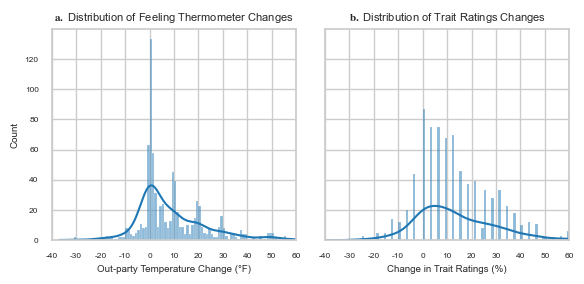

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set your plotting style
sns.set(style='whitegrid')

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

# Plot A: Out-party Temperature Change
sns.histplot(
    data['outpartyTemp_change'],
    bins=range(-40, 61, 1),
    kde=True,
    ax=axes[0],
    color='tab:blue',
    edgecolor=None
)
# axes[0].set_title('Feeling Thermometer Change')
axes[0].set_title(r'$\mathbf{a.}$ Distribution of Feeling Thermometer Changes', fontsize=8)
axes[0].set_xlabel('Out-party Temperature Change (°F)', fontsize=7)
axes[0].set_ylabel('Count', fontsize=7)
axes[0].set_xticks(np.arange(-40, 61, 10))
axes[0].set_xticklabels(np.arange(-40, 61, 10), fontsize=6)
axes[0].set_xlim(-40, 60)
# axes[0].set_ylim(0, 100)
axes[0].set_yticks(np.arange(0, 121, 20))
axes[0].set_yticklabels(np.arange(0, 121, 20), fontsize=6)


# Plot B: Trait Ratings Change (%)
sns.histplot(
    data['trait_ratings_change_percent'],
    bins=range(-40, 61, 1),
    kde=True,
    ax=axes[1],
    color='tab:blue',
    edgecolor=None
)
axes[1].set_title(r'$\mathbf{b.}$ Distribution of Trait Ratings Changes', fontsize=8)
axes[1].set_xlabel('Change in Trait Ratings (%)', fontsize=7)
axes[1].set_xticks(np.arange(-40, 61, 10))
axes[1].set_xticklabels(np.arange(-40, 61, 10), fontsize=6)
axes[1].set_xlim(-40, 60)



# Tight layout and save
plt.tight_layout()
plt.savefig('fig_change_histograms_kde.pdf', format='pdf')
plt.show()

In [16]:
print(f'Percent of discussants with outpartyTemp change within [-1,1] {100*data[(data["outpartyTemp_change"] < 1) & (data["outpartyTemp_change"] > -1)].shape[0] / data.shape[0]}')
print(f'Percent of discussants with Trait Ratings change within [-1,1] {100*data[(data["trait_ratings_change"] < .03) & (data["trait_ratings_change"] > -.03)].shape[0] / data.shape[0]}')

Percent of discussants with outpartyTemp change within [-1,1] 16.52173913043478
Percent of discussants with Trait Ratings change within [-1,1] 10.807453416149068


In [17]:
# Fixed Effect R-squared
topic_fixed_effect_model_feeling_thermometer = smf.ols('outpartyTemp_change ~ C(discussionTopic)', data=data).fit()
topic_fixed_effect_model_trait_ratings = smf.ols('trait_ratings_change_percent ~ C(discussionTopic)', data=data).fit()

r2_table["Topic Fixed Effect"] = [topic_fixed_effect_model_feeling_thermometer.rsquared, topic_fixed_effect_model_trait_ratings.rsquared]

# Topic Fixed Effect + Disagreement
topic_fixed_effect_disagreement_feeling_thermometer = smf.ols('outpartyTemp_change ~ C(discussionTopic) + disagreement', data=data).fit()
topic_fixed_effect_disagreement_trait_ratings = smf.ols('trait_ratings_change_percent ~ C(discussionTopic) + disagreement', data=data).fit()

r2_table["Topic Fixed Effect + Disagreement"] = [topic_fixed_effect_disagreement_feeling_thermometer.rsquared, topic_fixed_effect_disagreement_trait_ratings.rsquared]
r2_table


,Topic Features,Topic Features + Disagreement,Topic Fixed Effect,Topic Fixed Effect + Disagreement
Feeling Thermometers,0.011276,0.011421,0.019879,0.020045
Trait Ratings,0.001205,0.001226,0.009495,0.009531


# Secondary predictors show minimal influence

In [18]:

# Define outcomes.
outcomes = ["outpartyTemp_change", "trait_ratings_change_percent"]

# Nested predictors (with groups and human‑readable labels).
other_predictors_1 = {
    "Attitude Attributes": {
        "importance": "Importance of Topic",
        "knowledge": "Self Reported Knowledge",
        "certainty": "Certainty of Opinion",
        "ambivalence": "Ambivalence",
        "personalRelevance": "Personal Relevance",
        "moralConviction": "Moral Conviction",
        "elaboration": "Extent of Thinking"
    },
    "Personality Traits": {
        "normExtroversion": "Extroversion",
        "normAgreeableness": "Agreeableness",
        "normConscientiousness": "Conscientiousness",
        "normEmotionalStability": "Emotional Stability",
        "normOpennessToExperience": "Openness to Experience",
        "normRMEScore": "Social Perceptiveness",
    },
    "Demographics": {
        "age": "Age",
        "gender_female": "Gender (Female)",
        "language_English": "English First Language",
        "race_White": "Race (White)",
        "education_US": "Education",
    },
    "Political Attitudes": {
        "party_extremity": "Partisan Extremity",
        "party_normImportance": "Importance of Partisan Identity",
        "pretest_outpartyTemp": "Pretest Out-party Temperature",
        "pretest_normOverallAffect_scaled": "Pretest Trait Ratings",
        # "heterodoxy": "Heterodoxy from Party",
    },
}

# Define a helper function to run a univariate regression on one predictor.
def run_univariate_regression(data, predictor, outcome):
    df = data[[predictor, outcome]].dropna()
    X = sm.add_constant(df[predictor])
    y = df[outcome]
    model = sm.OLS(y, X).fit()
    coef = model.params[predictor]
    pval = model.pvalues[predictor]
    return coef, pval

# Loop over each nested predictor group and outcome.
results = []
for group_name, predictors in other_predictors_1.items():
    for predictor, predictor_label in predictors.items():
        row = {"Group": group_name, "Predictor": predictor, "Predictor_label": predictor_label}
        for outcome in outcomes:
            coef, pval = run_univariate_regression(data, predictor, outcome)
            row[f"{outcome}_coef"] = coef
            row[f"{outcome}_pval"] = pval
        results.append(row)

# Convert results list to a DataFrame.
results_df = pd.DataFrame(results)

# Apply BH (FDR) correction on each outcome's p-values over the full set.
for outcome in outcomes:
    corrected = multipletests(results_df[f"{outcome}_pval"], method="fdr_bh")
    results_df[f"{outcome}_pval_corrected"] = corrected[1]

# Optionally, sort the DataFrame by group and then by predictor.
results_df = results_df.sort_values(by=["Group", "Predictor"])

# (You can inspect the DataFrame with results_df.head())
results_df

,Group,Predictor,Predictor_label,outpartyTemp_change_coef,outpartyTemp_change_pval,trait_ratings_change_percent_coef,trait_ratings_change_percent_pval,outpartyTemp_change_pval_corrected,trait_ratings_change_percent_pval_corrected
3,Attitude Attributes,ambivalence,Ambivalence,4.408271,2.625531e-02,-2.267479,3.376325e-01,1.155233e-01,4.642447e-01
2,Attitude Attributes,certainty,Certainty of Opinion,0.586833,7.347209e-01,4.213726,4.075099e-02,9.712214e-01,1.494203e-01
6,Attitude Attributes,elaboration,Extent of Thinking,0.591872,7.504892e-01,1.436604,5.167949e-01,9.712214e-01,5.983941e-01
0,Attitude Attributes,importance,Importance of Topic,0.105803,9.522572e-01,3.874283,6.529399e-02,9.729156e-01,1.795585e-01
1,Attitude Attributes,knowledge,Self Reported Knowledge,-1.173981,5.252041e-01,0.439418,8.417158e-01,7.702993e-01,8.817976e-01
5,Attitude Attributes,moralConviction,Moral Conviction,1.303556,4.407507e-01,4.120086,4.049056e-02,6.926082e-01,1.494203e-01
4,Attitude Attributes,personalRelevance,Personal Relevance,-1.452325,4.026036e-01,3.889834,5.951215e-02,6.813291e-01,1.795585e-01
13,Demographics,age,Age,-0.003618,9.227583e-01,0.016118,7.162862e-01,9.729156e-01,7.879149e-01
17,Demographics,education_US,Education,0.068115,8.630530e-01,-0.776726,9.766387e-02,9.729156e-01,1.953277e-01
14,Demographics,gender_female,Gender (Female),0.242975,8.120346e-01,1.504706,2.151177e-01,9.729156e-01,3.380421e-01


In [19]:
# Build the LaTeX table manually.
latex_lines = []

# Begin the table with a column specification: left-aligned for the predictor, centered for the two outcome columns.
latex_lines.append(r"\begin{tabular}{lcc}")
latex_lines.append(r"\hline")
latex_lines.append(r"Predictor & \textbf{Feeling Thermometer} & \textbf{Trait Ratings} \\")
latex_lines.append(r"\hline")

# Loop over groups in the desired order.
for group in other_predictors_1.keys():
    # Insert a group header row spanning all columns.
    latex_lines.append(r"\multicolumn{3}{l}{\textbf{" + group + r"}} \\")
    
    # For each predictor in this group (using the order in your nested dictionary)
    for predictor, predictor_label in other_predictors_1[group].items():
        # Filter the results DataFrame for the current predictor.
        df_row = results_df[results_df["Predictor"] == predictor]
        if df_row.empty:
            continue  # Skip if no result for this predictor.
        row = df_row.iloc[0]
        
        # Check if the p-value is below .05 to bold the coefficient.
        temp_coef = f"{row['outpartyTemp_change_coef']:.2f}"
        if row['outpartyTemp_change_pval_corrected'] < 0.05:
            temp_coef = r"\textbf{" + temp_coef + "}"
        trait_coef = f"{row['trait_ratings_change_percent_coef']:.2f}"
        if row['trait_ratings_change_percent_pval_corrected'] < 0.05:
            trait_coef = r"\textbf{" + trait_coef + "}"
        
        # Format the outcome cells using \makecell for a two-line cell.
        cell_temp = (r"\makecell{" 
                     + temp_coef
                     + r"  (" + f"{row['outpartyTemp_change_pval_corrected']:.3f}" + r")}")
        cell_trait = (r"\makecell{" 
                      + trait_coef
                      + r"  (" + f"{row['trait_ratings_change_percent_pval_corrected']:.3f}" + r")}")
        
        # Build the predictor row. The predictor label is indented (using \quad).
        latex_lines.append(r"\quad " + predictor_label + " & " + cell_temp + " & " + cell_trait + r" \\")
    
    # Optionally add a horizontal line after each group.
    latex_lines.append(r"\hline")

latex_lines.append(r"\multicolumn{3}{l}{\footnotesize Univariate regression coefficients (Benjamini-Hochberg corrected p-values). } \\")
latex_lines.append(r"\multicolumn{3}{l}{\footnotesize Both waves included. See SI for measurement details.} \\")
latex_lines.append(r"\hline")

latex_lines.append(r"\end{tabular}")

# Combine all lines into one string.
latex_table = "\n".join(latex_lines)

# Write the table to a .tex file.
with open("table_secondary_predictors_attributes.tex", "w") as f:
    f.write(latex_table)

print(latex_table)

\begin{tabular}{lcc}
\hline
Predictor & \textbf{Feeling Thermometer} & \textbf{Trait Ratings} \\
\hline
\multicolumn{3}{l}{\textbf{Attitude Attributes}} \\
\quad Importance of Topic & \makecell{0.11  (0.973)} & \makecell{3.87  (0.180)} \\
\quad Self Reported Knowledge & \makecell{-1.17  (0.770)} & \makecell{0.44  (0.882)} \\
\quad Certainty of Opinion & \makecell{0.59  (0.971)} & \makecell{4.21  (0.149)} \\
\quad Ambivalence & \makecell{4.41  (0.116)} & \makecell{-2.27  (0.464)} \\
\quad Personal Relevance & \makecell{-1.45  (0.681)} & \makecell{3.89  (0.180)} \\
\quad Moral Conviction & \makecell{1.30  (0.693)} & \makecell{4.12  (0.149)} \\
\quad Extent of Thinking & \makecell{0.59  (0.971)} & \makecell{1.44  (0.598)} \\
\hline
\multicolumn{3}{l}{\textbf{Personality Traits}} \\
\quad Extroversion & \makecell{2.58  (0.359)} & \makecell{2.24  (0.453)} \\
\quad Agreeableness & \makecell{5.36  (0.166)} & \makecell{5.59  (0.180)} \\
\quad Conscientiousness & \makecell{2.36  (0.675)} & \mak

In [20]:
import statsmodels.formula.api as smf

# Flatten the nested predictors into a single list.
all_predictors = []
for group, predictors in other_predictors_1.items():
    for predictor in predictors.keys():
        all_predictors.append(predictor)


individual_features_feeling_thermometer = smf.ols(formula = 'outpartyTemp_change ~ ' + ' + '.join(all_predictors) , data=data).fit()
r2_table.loc[ "Feeling Thermometers", "Individual Features"] = individual_features_feeling_thermometer.rsquared

individual_features_trait_ratings = smf.ols(formula = 'trait_ratings_change ~ ' + ' + '.join(all_predictors) , data=data).fit()
r2_table.loc[ "Trait Ratings", "Individual Features"] = individual_features_trait_ratings.rsquared


individual_features_topics_disagreement_feeling_thermometer = smf.ols(formula = 'outpartyTemp_change ~ ' + ' + '.join(all_predictors) + ' + C(discussionTopic)  + disagreement' , data=data).fit()
r2_table.loc[ "Feeling Thermometers", "Individual Features + Topic Fixed Effect + Disagreement"] = individual_features_topics_disagreement_feeling_thermometer.rsquared

individual_features_topics_disagreement_trait_ratings = smf.ols(formula = 'trait_ratings_change ~ ' + ' + '.join(all_predictors) + ' + C(discussionTopic)  + disagreement', data=data).fit()
r2_table.loc[ "Trait Ratings", "Individual Features + Topic Fixed Effect + Disagreement"] = individual_features_topics_disagreement_trait_ratings.rsquared


r2_table

,Topic Features,Topic Features + Disagreement,Topic Fixed Effect,Topic Fixed Effect + Disagreement,Individual Features,Individual Features + Topic Fixed Effect + Disagreement
Feeling Thermometers,0.011276,0.011421,0.019879,0.020045,0.115233,0.134011
Trait Ratings,0.001205,0.001226,0.009495,0.009531,0.221862,0.229876


# Conversation behaviors are more predictive

In [21]:

# Define outcomes.
outcomes = ["outpartyTemp_change", "trait_ratings_change_percent"]

# Nested predictors (with groups and human‑readable labels).
other_predictors_2 = {
    "Experience of Discussion": {
        'discussionEnjoy': 'Enjoyment of Discussion',
        'discussionDepth': 'Discussion Depth',
        'discussionDisagreement': 'Perceived Disagreement',
        'discussionTension': 'Discussion Tension',
        'selfSpeakUp': 'Chance to Speak',
        'selfVoice': 'Comfort Sharing Opinions',
        'selfAnxious': 'Feeling Anxious',
        'selfJudged': 'Feeling Judged',
        'selfInsight': 'Self Insight',
        'selfLearned': 'Learned from Discussion',
    },
    "Experience of Partner": {
        'normCommon': 'Perceived In Common with Partner',
        'normSelfPerspectiveTaking': "Ability to Take Partner's Perspective",
        'normPartnerPerspectiveTaking': "Partner Takes R's Perspective",
        'normPartnerTalking': 'Partner Talks More',
        'normPartnerReceptiveness': "Partner is Receptive",
        'normPolite': 'Partner is Polite',
        'normPartnerListening':"Partner Listens Well",
        'normLiking': 'Liking Partner',
    },
}

# Define a helper function to run a univariate regression on one predictor.
def run_univariate_regression(data, predictor, outcome):
    df = data[[predictor, outcome]].dropna()
    X = sm.add_constant(df[predictor])
    y = df[outcome]
    model = sm.OLS(y, X).fit()
    coef = model.params[predictor]
    pval = model.pvalues[predictor]
    return coef, pval

# Loop over each nested predictor group and outcome.
results = []
for group_name, predictors in other_predictors_2.items():
    for predictor, predictor_label in predictors.items():
        row = {"Group": group_name, "Predictor": predictor, "Predictor_label": predictor_label}
        for outcome in outcomes:
            coef, pval = run_univariate_regression(data, predictor, outcome)
            row[f"{outcome}_coef"] = coef
            row[f"{outcome}_pval"] = pval
        results.append(row)

# Convert results list to a DataFrame.
results_df_2 = pd.DataFrame(results)

# Apply BH (FDR) correction on each outcome's p-values over the full set.
for outcome in outcomes:
    corrected = multipletests(results_df_2[f"{outcome}_pval"], method="fdr_bh")
    results_df_2[f"{outcome}_pval_corrected"] = corrected[1]

# Optionally, sort the DataFrame by group and then by predictor.
results_df_2 = results_df_2.sort_values(by=["Group", "Predictor"])

results_df_2

,Group,Predictor,Predictor_label,outpartyTemp_change_coef,outpartyTemp_change_pval,trait_ratings_change_percent_coef,trait_ratings_change_percent_pval,outpartyTemp_change_pval_corrected,trait_ratings_change_percent_pval_corrected
1,Experience of Discussion,discussionDepth,Discussion Depth,8.703184,2.673194e-05,11.710698,1.867780e-06,4.374318e-05,3.362005e-06
2,Experience of Discussion,discussionDisagreement,Perceived Disagreement,-2.808859,1.445403e-01,-7.268706,1.431181e-03,1.445403e-01,1.781491e-03
0,Experience of Discussion,discussionEnjoy,Enjoyment of Discussion,15.063127,3.101947e-12,22.710260,3.864776e-19,2.791753e-11,6.956597e-18
3,Experience of Discussion,discussionTension,Discussion Tension,-12.191822,1.469238e-05,-14.328961,1.793727e-05,2.644629e-05,2.690590e-05
6,Experience of Discussion,selfAnxious,Feeling Anxious,-3.472817,6.706206e-02,-6.361335,4.662403e-03,8.125326e-02,4.662403e-03
8,Experience of Discussion,selfInsight,Self Insight,11.844996,6.727086e-10,12.448784,5.044437e-08,3.027189e-09,1.134998e-07
7,Experience of Discussion,selfJudged,Feeling Judged,-6.405546,4.789527e-02,-11.685638,1.484576e-03,6.631653e-02,1.781491e-03
9,Experience of Discussion,selfLearned,Learned from Discussion,11.977204,1.525760e-10,11.989644,7.513007e-08,9.154560e-10,1.502601e-07
4,Experience of Discussion,selfSpeakUp,Chance to Speak,13.961826,5.158347e-06,16.416724,6.365766e-06,1.135679e-05,1.041671e-05
5,Experience of Discussion,selfVoice,Comfort Sharing Opinions,13.310653,5.678395e-06,19.016094,4.334098e-08,1.135679e-05,1.114482e-07


In [22]:
# Build the LaTeX table manually.
latex_lines = []

# Begin the table with a column specification: left-aligned for the predictor, centered for the two outcome columns.
latex_lines.append(r"\begin{tabular}{lcc}")
latex_lines.append(r"\hline")
latex_lines.append(r"Predictor & \textbf{Feeling Thermometer} & \textbf{Trait Ratings} \\")
latex_lines.append(r"\hline")

# Loop over groups in the desired order.
for group in other_predictors_2.keys():
    # Insert a group header row spanning all columns.
    latex_lines.append(r"\multicolumn{3}{l}{\textbf{" + group + r"}} \\")
    
    # For each predictor in this group (using the order in your nested dictionary)
    for predictor, predictor_label in other_predictors_2[group].items():
        # Filter the results DataFrame for the current predictor.
        df_row = results_df_2[results_df_2["Predictor"] == predictor]
        if df_row.empty:
            continue  # Skip if no result for this predictor.
        row = df_row.iloc[0]
        
        # Check if the p-value is below .05 to bold the coefficient.
        temp_coef = f"{row['outpartyTemp_change_coef']:.3f}"
        if row['outpartyTemp_change_pval_corrected'] < 0.05:
            temp_coef = r"\textbf{" + temp_coef + "}"
        trait_coef = f"{row['trait_ratings_change_percent_coef']:.3f}"
        if row['trait_ratings_change_percent_pval_corrected'] < 0.05:
            trait_coef = r"\textbf{" + trait_coef + "}"
        
        # Format the outcome cells using \makecell for a two-line cell.
        cell_temp = (r"\makecell{" 
                     + temp_coef
                     + r"  (" + f"{row['outpartyTemp_change_pval_corrected']:.3f}" + r")}")
        cell_trait = (r"\makecell{" 
                      + trait_coef
                      + r"  (" + f"{row['trait_ratings_change_percent_pval_corrected']:.3f}" + r")}")
        
        # Build the predictor row. The predictor label is indented (using \quad).
        latex_lines.append(r"\quad " + predictor_label + " & " + cell_temp + " & " + cell_trait + r" \\")
    
    # Optionally add a horizontal line after each group.
    latex_lines.append(r"\hline")

latex_lines.append(r"\multicolumn{3}{l}{\footnotesize Univariate regression coefficients (Benjamini-Hochberg corrected p-values). } \\")
latex_lines.append(r"\multicolumn{3}{l}{\footnotesize Both waves included. See SI for measurement details.} \\")
latex_lines.append(r"\hline")

latex_lines.append(r"\end{tabular}")

# Combine all lines into one string.
latex_table = "\n".join(latex_lines)

# Write the table to a .tex file.
with open("table_secondary_predictors_behavior.tex", "w") as f:
    f.write(latex_table)

print(latex_table)

\begin{tabular}{lcc}
\hline
Predictor & \textbf{Feeling Thermometer} & \textbf{Trait Ratings} \\
\hline
\multicolumn{3}{l}{\textbf{Experience of Discussion}} \\
\quad Enjoyment of Discussion & \makecell{\textbf{15.063}  (0.000)} & \makecell{\textbf{22.710}  (0.000)} \\
\quad Discussion Depth & \makecell{\textbf{8.703}  (0.000)} & \makecell{\textbf{11.711}  (0.000)} \\
\quad Perceived Disagreement & \makecell{-2.809  (0.145)} & \makecell{\textbf{-7.269}  (0.002)} \\
\quad Discussion Tension & \makecell{\textbf{-12.192}  (0.000)} & \makecell{\textbf{-14.329}  (0.000)} \\
\quad Chance to Speak & \makecell{\textbf{13.962}  (0.000)} & \makecell{\textbf{16.417}  (0.000)} \\
\quad Comfort Sharing Opinions & \makecell{\textbf{13.311}  (0.000)} & \makecell{\textbf{19.016}  (0.000)} \\
\quad Feeling Anxious & \makecell{-3.473  (0.081)} & \makecell{\textbf{-6.361}  (0.005)} \\
\quad Feeling Judged & \makecell{-6.406  (0.066)} & \makecell{\textbf{-11.686}  (0.002)} \\
\quad Self Insight & \makecel

In [23]:
# Flatten the nested predictors into a single list.
all_predictors = []
for group, predictors in other_predictors_2.items():
    for predictor in predictors.keys():
        all_predictors.append(predictor)


behaviors_feeling_thermometer = smf.ols(formula = 'outpartyTemp_change ~ ' + ' + '.join(all_predictors) , data=data).fit()
r2_table.loc[ "Feeling Thermometers", "Behaviors"] = behaviors_feeling_thermometer.rsquared

behaviors_trait_ratings = smf.ols(formula = 'trait_ratings_change ~ ' + ' + '.join(all_predictors) , data=data).fit()
r2_table.loc[ "Trait Ratings", "Behaviors"] = behaviors_trait_ratings.rsquared


all_predictors = []
for group, predictors in other_predictors_1.items():
    for predictor in predictors.keys():
        all_predictors.append(predictor)

for group, predictors in other_predictors_2.items():
    for predictor in predictors.keys():
        all_predictors.append(predictor)


behaviors_individual_features_topics_disagreement_feeling_thermometer = smf.ols(formula = 'outpartyTemp_change ~ ' + ' + '.join(all_predictors) + ' + C(discussionTopic)  + disagreement' , data=data).fit()
r2_table.loc[ "Feeling Thermometers", "Behaviors + Individual Features + Topic Fixed Effect + Disagreement"] = behaviors_individual_features_topics_disagreement_feeling_thermometer.rsquared

behaviors_individual_features_topics_disagreement_trait_ratings = smf.ols(formula = 'trait_ratings_change ~ ' + ' + '.join(all_predictors) + ' + C(discussionTopic)  + disagreement', data=data).fit()
r2_table.loc[ "Trait Ratings", "Behaviors + Individual Features + Topic Fixed Effect + Disagreement"] = behaviors_individual_features_topics_disagreement_trait_ratings.rsquared

r2_table

,Topic Features,Topic Features + Disagreement,Topic Fixed Effect,Topic Fixed Effect + Disagreement,Individual Features,Individual Features + Topic Fixed Effect + Disagreement,Behaviors,Behaviors + Individual Features + Topic Fixed Effect + Disagreement
Feeling Thermometers,0.011276,0.011421,0.019879,0.020045,0.115233,0.134011,0.130122,0.303652
Trait Ratings,0.001205,0.001226,0.009495,0.009531,0.221862,0.229876,0.138851,0.419155


In [24]:
# Note: takes most of an hour to run the bootstraps
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm.auto import tqdm  # for a progress bar

def compute_diff_and_ci(df, predictor, outcome, n_boot=10_000, ci=(2.5, 97.5)):
    """
    Fit y ~ x univariately on df, return:
      - point_estimate = |pred(max x) - pred(min x)|
      - ci_lower, ci_upper from bootstrap
    """
    df0 = df.dropna(subset=[predictor, outcome])
    if df0.empty:
        return np.nan, np.nan, np.nan

    # point estimate
    formula = f"{outcome} ~ {predictor}"
    m0 = smf.ols(formula, data=df0).fit()
    vmin, vmax = df0[predictor].min(), df0[predictor].max()
    pmin = m0.predict({predictor: vmin})[0]
    pmax = m0.predict({predictor: vmax})[0]
    point = abs(pmax - pmin)

    # bootstrap
    boots = np.empty(n_boot)
    for i in range(n_boot):
        samp = df0.sample(frac=1.0, replace=True)
        mb = smf.ols(formula, data=samp).fit()
        vmin_b, vmax_b = samp[predictor].min(), samp[predictor].max()
        pmin_b = mb.predict({predictor: vmin_b})[0]
        pmax_b = mb.predict({predictor: vmax_b})[0]
        boots[i] = abs(pmax_b - pmin_b)

    lower, upper = np.percentile(boots, ci)
    return point, lower, upper

# --- now build your table ---

all_effects = []

# helper to loop a dict of predictors
def process_group(group_name, pred_dict, group_label):
    for predictor, label in pred_dict.items():
        pt, lo, hi = compute_diff_and_ci(data, predictor, 'outpartyTemp_change')
        pt2, lo2, hi2 = compute_diff_and_ci(data, predictor, 'trait_ratings_change_percent')
        all_effects.append({
            "Predictor":         predictor,
            "Label":             label,
            "Group":             group_label,
            "Difference_temp":   pt,
            "CI_lower_temp":     lo,
            "CI_upper_temp":     hi,
            "Difference_trait":  pt2,
            "CI_lower_trait":    lo2,
            "CI_upper_trait":    hi2,
        })

# IVs
process_group("IVs", IVs, "IVs")

# other_predictors_1
process_group("other_predictors_1", 
              {k:v for grp in other_predictors_1.values() for k,v in grp.items()},
              "other_predictors_1")

# other_predictors_2
process_group("other_predictors_2", 
              {k:v for grp in other_predictors_2.values() for k,v in grp.items()},
              "other_predictors_2")

# assemble DataFrame
differences_df = pd.DataFrame(all_effects)

# drop any NaNs and sort by the main effect
differences_df = differences_df.dropna(subset=["Difference_temp","Difference_trait"])
differences_df = differences_df.sort_values("Difference_temp", ascending=False)

differences_df.index = range(len(differences_df))
differences_df

/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Predictor,Label,Group,Difference_temp,CI_lower_temp,CI_upper_temp,Difference_trait,CI_lower_trait,CI_upper_trait
0,normLiking,Liking Partner,other_predictors_2,17.401656,13.020050,21.647416,23.738906,18.319332,29.371590
1,normPartnerListening,Partner Listens Well,other_predictors_2,16.949726,11.362150,22.524219,26.028432,19.774964,32.895143
2,discussionEnjoy,Enjoyment of Discussion,other_predictors_2,15.063127,11.466890,18.712107,22.710260,18.289768,27.243884
3,pretest_outpartyTemp,Pretest Out-party Temperature,other_predictors_1,14.174411,10.412886,17.924353,8.516357,3.546713,13.402849
4,selfSpeakUp,Chance to Speak,other_predictors_2,13.961826,8.365023,19.729689,16.416724,10.251456,22.594637
5,selfVoice,Comfort Sharing Opinions,other_predictors_2,13.310653,7.143494,19.484149,19.016094,12.090688,26.076381
6,normCommon,Perceived In Common with Partner,other_predictors_2,12.359388,7.827797,16.842332,14.981296,9.328792,20.502348
7,normPartnerPerspectiveTaking,Partner Takes R's Perspective,other_predictors_2,12.233174,8.385818,16.247251,19.089666,14.529121,23.771040
8,discussionTension,Discussion Tension,other_predictors_2,12.191822,6.360729,17.676640,14.328961,7.100784,21.157109
9,selfLearned,Learned from Discussion,other_predictors_2,11.977204,8.411970,15.478887,11.989644,7.927303,16.137859


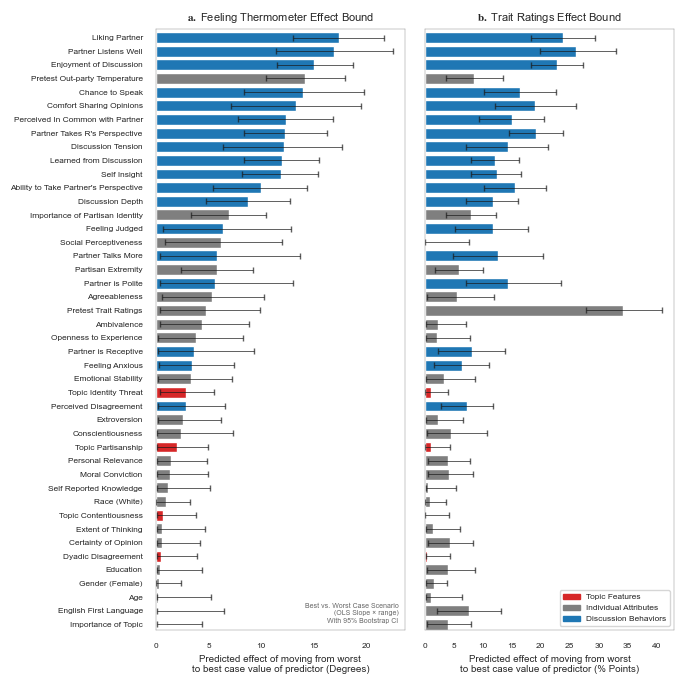

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# colors already set up
group_colors = {
    "IVs": "tab:red",
    "other_predictors_1": "tab:gray",
    "other_predictors_2": "tab:blue"
}
differences_df["Color"] = differences_df["Group"].map(group_colors)
n = len(differences_df)

fig, axs = plt.subplots(1, 2, figsize=(7, 7), sharey=True)

# --- Left panel: Temp effect + CI ---
errs_temp = np.vstack([
    np.abs(differences_df["Difference_temp"] - differences_df["CI_lower_temp"]),
    np.abs(differences_df["CI_upper_temp"] - differences_df["Difference_temp"])
])
axs[0].barh(
    differences_df["Label"],
    differences_df["Difference_temp"],
    xerr=errs_temp,
    color=differences_df["Color"],
    error_kw={"capsize":2, "alpha":0.7, "linewidth":0.7}
)
axs[0].set_xlabel("Predicted effect of moving from worst\nto best case value of predictor (Degrees)", fontsize=7)
axs[0].set_title(r'$\mathbf{a.}$ Feeling Thermometer Effect Bound', fontsize=8)
axs[0].tick_params(axis='x', labelsize=6)
axs[0].tick_params(axis='y', labelsize=6)
axs[0].set_ylim(n - 0.6, -0.6)

# --- Right panel: Trait effect + CI ---
errs_trait = np.vstack([
    np.abs(differences_df["Difference_trait"] - differences_df["CI_lower_trait"]),
    np.abs(differences_df["CI_upper_trait"] - differences_df["Difference_trait"])
])
axs[1].barh(
    differences_df["Label"],
    differences_df["Difference_trait"],
    xerr=errs_trait,
    color=differences_df["Color"],
    error_kw={"capsize":2, "alpha":0.7, "linewidth":0.7}
)
axs[1].set_xlabel("Predicted effect of moving from worst\nto best case value of predictor (% Points)", fontsize=7)
axs[1].set_title(r'$\mathbf{b.}$ Trait Ratings Effect Bound', fontsize=8)
axs[1].tick_params(axis='x', labelsize=6)
axs[1].tick_params(axis='y', labelleft=False)
axs[1].set_ylim(n - 0.6, -0.6)
axs[1].set_xlim(0, 43)

# legend
patches = [
    mpatches.Patch(color=group_colors["IVs"],               label="Topic Features"),
    mpatches.Patch(color=group_colors["other_predictors_1"], label="Individual Attributes"),
    mpatches.Patch(color=group_colors["other_predictors_2"], label="Discussion Behaviors"),
]
axs[1].legend(handles=patches, loc='lower right', fontsize=6, frameon=True)

# note inset
axs[0].text(
    0.975, 0.01,
    "Best vs. Worst Case Scenario\n(OLS Slope × range)\nWith 95% Bootstrap CI",
    transform=axs[0].transAxes,
    ha='right', va='bottom',
    fontsize=5, color='dimgray'
)

# tidy up spines
for ax in axs:
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.3)

plt.tight_layout()
plt.savefig('fig_best_case_with_ci.pdf')
plt.show()

In [26]:
print(f"Effects of each predictor on the two dependent variables are correlated at {differences_df['Difference_temp'].corr(differences_df['Difference_trait']):.2f}, pvalue={stats.pearsonr(differences_df['Difference_temp'], differences_df['Difference_trait'])[1]:.8f}.")

Effects of each predictor on the two dependent variables are correlated at 0.75, pvalue=0.00000000.


# Methods Section

In [27]:
print(f'Participant Pool % Female {data["gender_female"].value_counts(normalize=True)[1] * 100:.2f}%')
print(f"Participant pool age and std: {data['age'].mean():.2f} ± {data['age'].std():.2f}")
print(f"Participant pool fraction with bachelors degree or higher {(data['education_US']>=6).value_counts(normalize=True)[True]*100:.2f}%")

Participant Pool % Female 52.42%
Participant pool age and std: 41.40 ± 13.68
Participant pool fraction with bachelors degree or higher 62.73%


In [28]:
data["party"].value_counts(normalize=True)

party
Democrat       0.485714
Republican     0.483230
Independent    0.031056
Name: proportion, dtype: float64

In [29]:
# Proportion of participants with a bachelor's degree or higher
(data['education_US']>=6).value_counts(normalize=True)

education_US
True     0.627329
False    0.372671
Name: proportion, dtype: float64

# Robustness Checks

## Dropouts are not substantially different from other participants on observed measures

In [30]:
attritters["reports"].apply(lambda x: x != "[]").sum() / attritters.shape[0]

np.float64(0.5486725663716814)

In [31]:
attritters["reports"].iloc[0]

"[{'code': 'onlyOne', 'stage': 'game_2_Discussion', 'timestamp': 49.405}]"

In [32]:
from scipy.stats import ttest_ind

# We want to compare only the following three groups:
groups_to_compare = ["Personality Traits", "Demographics", "Political Attitudes"]

# Initialize a list to hold the test results.
results_list = []

# Loop over the selected groups.
for group in groups_to_compare:
    for attribute, label in other_predictors_1[group].items():
        # Extract the series from each DataFrame. We assume that the column names match.
        sample_data = data[attribute].dropna()
        sample_attritters = attritters[attribute].dropna()
        
        # Run Welch's independent-samples t-test.
        # Note: if sample sizes are very different or variances differ, using equal_var=False is more robust.
        t_stat, p_val = ttest_ind(sample_data, sample_attritters, equal_var=False)
        
        results_list.append({
            "Group": group,
            "Attribute": label,
            "t-statistic": t_stat,
            "p-value": p_val
        })

# Convert the list to a DataFrame.
results_df = pd.DataFrame(results_list)

# Optionally, sort the results by p-value or t-statistic.
results_df = results_df.sort_values(by="p-value")

results_df

,Group,Attribute,t-statistic,p-value
12,Political Attitudes,Importance of Partisan Identity,-1.578751,0.115245
7,Demographics,Gender (Female),-1.484872,0.138443
2,Personality Traits,Conscientiousness,1.185842,0.236456
11,Political Attitudes,Partisan Extremity,-1.030237,0.303589
5,Personality Traits,Social Perceptiveness,0.938358,0.348684
8,Demographics,English First Language,-0.727043,0.467595
14,Political Attitudes,Pretest Trait Ratings,-0.717986,0.473248
13,Political Attitudes,Pretest Out-party Temperature,0.575136,0.565553
9,Demographics,Race (White),-0.551450,0.581662
10,Demographics,Education,0.516551,0.605796


In [33]:
# Build the LaTeX table manually.
latex_lines = []

# Begin the table with a column specification: left-aligned for the attribute,
# centered for the two numeric columns.
latex_lines.append(r"\begin{tabular}{lcc}")
latex_lines.append(r"\hline")
latex_lines.append(r"Attribute & t-statistic & p-value \\")
latex_lines.append(r"\hline")

# Optionally, define an order for the groups if desired.
group_order = ["Personality Traits", "Demographics", "Political Attitudes"]

# Loop over each group in the desired order.
for group in group_order:
    # Insert a group header row spanning all columns.
    latex_lines.append(r"\multicolumn{3}{l}{\textbf{" + group + r"}} \\")
    
    # Select rows for this group.
    group_df = results_df[results_df["Group"] == group]
    
    # Loop over each row in this group.
    for index, row in group_df.iterrows():
        # Get the attribute's human-readable name,
        # the t-statistic, and the p-value.
        attr = row["Attribute"]
        t_stat = row["t-statistic"]
        p_val = row["p-value"]
        # Format the row.
        latex_lines.append(" " + attr + " & " + f"{t_stat:.3f}" + " & " + f"{p_val:.3f}" + r" \\")
    
    # Optional horizontal line between groups.
    latex_lines.append(r"\hline")

latex_lines.append(r"\end{tabular}")

# Combine all lines into one LaTeX string.
latex_table = "\n".join(latex_lines)

# Write the LaTeX table to a .tex file.
with open("table_attrition_t_test.tex", "w") as f:
    f.write(latex_table)

print(latex_table)

\begin{tabular}{lcc}
\hline
Attribute & t-statistic & p-value \\
\hline
\multicolumn{3}{l}{\textbf{Personality Traits}} \\
 Conscientiousness & 1.186 & 0.236 \\
 Social Perceptiveness & 0.938 & 0.349 \\
 Agreeableness & 0.360 & 0.719 \\
 Extroversion & 0.211 & 0.833 \\
 Openness to Experience & -0.170 & 0.865 \\
 Emotional Stability & -0.147 & 0.883 \\
\hline
\multicolumn{3}{l}{\textbf{Demographics}} \\
 Gender (Female) & -1.485 & 0.138 \\
 English First Language & -0.727 & 0.468 \\
 Race (White) & -0.551 & 0.582 \\
 Education & 0.517 & 0.606 \\
 Age & 0.206 & 0.837 \\
\hline
\multicolumn{3}{l}{\textbf{Political Attitudes}} \\
 Importance of Partisan Identity & -1.579 & 0.115 \\
 Partisan Extremity & -1.030 & 0.304 \\
 Pretest Trait Ratings & -0.718 & 0.473 \\
 Pretest Out-party Temperature & 0.575 & 0.566 \\
\hline
\end{tabular}


# Adaptive assignment allocates samples efficiently

/var/folders/2l/3kmvzs0s1sggnw_9sl0ls8080000gn/T/ipykernel_71154/985311071.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


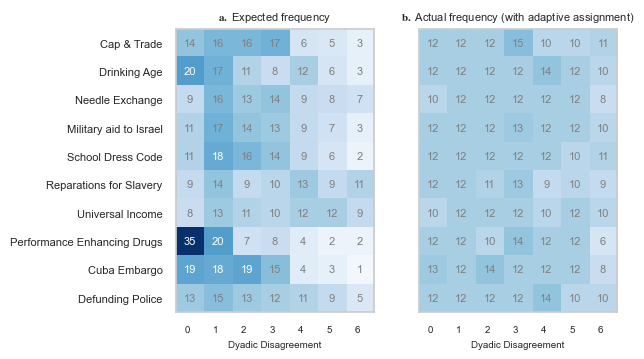

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ────────────────────────────────────────────────────────────────
# 0) Topic lists and short names
# ────────────────────────────────────────────────────────────────
shortNames = {
    "capAndTrade": "Cap & Trade",
    "drinkingAge": "Drinking Age",
    "fundNeedleExchange": "Needle Exchange",
    "israelAid": "Military aid to Israel",
    "schoolDressCode": "School Dress Code",
    "slaveReparations": "Reparations for Slavery",
    "universalIncome": "Universal Income",
    "sportsPEDs": "Performance Enhancing Drugs",
    "cubaEmbargo": "Cuba Embargo",
    "policeDefundingDiscrimination": "Defunding Police",
}
topics = list(shortNames.keys())
disagreement_levels = range(7)

# split into wave1 vs wave2 topics
wave1_topics = [
    "israelAid", "schoolDressCode", "fundNeedleExchange",
    "universalIncome", "slaveReparations"
]
wave2_topics = [t for t in topics if t not in wave1_topics]

# how many participants in each wave?
N1 = data[data.wave == 1].shape[0]
N2 = data[data.wave == 2].shape[0]

# ────────────────────────────────────────────────────────────────
# helper: simulate expected counts for one wave
# ────────────────────────────────────────────────────────────────
def simulate_expected_counts(wave, topic_list, N_wave):
    """Return a (len(topic_list) × 7) array of expected counts for this wave,
       scaled to exactly N_wave participants."""
    # Build per-topic pools filtered by wave
    idx = pd.MultiIndex.from_product([topic_list, disagreement_levels],
                                     names=["topic", "disagreement"])
    counts = pd.DataFrame(0, index=idx, columns=["count"])
    
    dems = {
        t: data[
            (data.wave == wave) &
            (data.party == "Democrat") &
            data[f"{t}_presurvey"].notna()
        ].index.values
        for t in topic_list
    }
    reps = {
        t: data[
            (data.wave == wave) &
            (data.party == "Republican") &
            data[f"{t}_presurvey"].notna()
        ].index.values
        for t in topic_list
    }
    # Check we have some candidates
    for t in topic_list:
        if dems[t].size == 0 or reps[t].size == 0:
            raise ValueError(f"No valid Dem/Rep for topic {t} in wave {wave}")
    
    # Simulate 10k draws
    n_draws = 10000
    for i in range(n_draws):
        t = topic_list[i % len(topic_list)]
        d = np.random.choice(dems[t])
        r = np.random.choice(reps[t])
        diff = abs(data.at[d, f"{t}_presurvey"] - data.at[r, f"{t}_presurvey"])
        bin_ = int(round(diff * 6))
        counts.at[(t, bin_), "count"] += 1
    
    # pivot, normalize, scale to N_wave
    mat = counts["count"].unstack("topic").T.loc[topic_list]
    props = mat / mat.values.sum()
    return (props * N_wave).values.astype(int)

# ────────────────────────────────────────────────────────────────
# 1) simulate for each wave and combine
# ────────────────────────────────────────────────────────────────
exp1 = simulate_expected_counts(wave=1, topic_list=wave1_topics, N_wave=N1)
exp2 = simulate_expected_counts(wave=2, topic_list=wave2_topics, N_wave=N2)

# build a 10×7 array in topic order
display_exp = np.zeros((len(topics), len(disagreement_levels)), dtype=int)
for i, t in enumerate(topics):
    if t in wave1_topics:
        j = wave1_topics.index(t)
        display_exp[i, :] = exp1[j, :]
    else:
        j = wave2_topics.index(t)
        display_exp[i, :] = exp2[j, :]

# ────────────────────────────────────────────────────────────────
# 2) compute actual counts
# ────────────────────────────────────────────────────────────────
filtered = data[data.discussionTopic.isin(topics)]
strat_counts = (
    filtered
    .groupby(["disagreement", "discussionTopic"])
    .size()
    .unstack(fill_value=0)
)
# ensure full index/order
strat_counts = strat_counts.reindex(index=disagreement_levels, fill_value=0)
act_mat = strat_counts[topics].T
display_act = act_mat.values.astype(int)

# ────────────────────────────────────────────────────────────────
# 3) plot side by side
# ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    1, 2,
    figsize=(7.2, 3.5),
    sharey=True,
    gridspec_kw={'wspace': -.3}   # shrink the gap between panels
)

# make room on the left so y‐labels aren’t clipped
fig.subplots_adjust(left=0.16, right=0.98, top=0.93, bottom=0.12)

norm = Normalize(vmin=0, vmax=max(display_exp.max(), display_act.max()))

# --- Left: Expected ---
ax = axes[0]
im = ax.imshow(display_exp, cmap="Blues", norm=norm)
ax.set_title(r'$\mathbf{a.}$ Expected frequency', fontsize=8)
ax.set_xlabel("Dyadic Disagreement", fontsize=7)
ax.set_xticks(range(7))
ax.set_xticklabels(range(7), ha="right", fontsize=7)
ax.grid(False)

# y‐ticks on left only
ax.set_yticks(np.arange(len(topics)))
ax.set_yticklabels([shortNames[t] for t in topics], fontsize=8)
ax.tick_params(axis='y', labelleft=True)

# annotate
for i in range(display_exp.shape[0]):
    for j in range(display_exp.shape[1]):
        v = display_exp[i, j]
        c = "white" if v > norm.vmax/2 else "gray"
        ax.text(j, i, v, ha="center", va="center", color=c, fontsize=8)

# --- Right: Actual ---
ax = axes[1]
ax.imshow(display_act, cmap="Blues", norm=norm)
ax.set_title(r'$\mathbf{b.}$ Actual frequency (with adaptive assignment)', fontsize=8)
ax.set_xlabel("Dyadic Disagreement", fontsize=7)
ax.set_xticks(range(7))
ax.set_xticklabels(range(7), ha="right", fontsize=7)
ax.grid(False)

# hide y‐labels on right
ax.set_yticks(np.arange(len(topics)))
# ax.set_yticklabels([])
ax.tick_params(axis='y', labelleft=False)

# annotate
for i in range(display_act.shape[0]):
    for j in range(display_act.shape[1]):
        v = display_act[i, j]
        c = "white" if v > norm.vmax/2 else "gray"
        ax.text(j, i, v, ha="center", va="center", color=c, fontsize=8)

plt.tight_layout()
plt.savefig("fig_balanced_samples.pdf", format="pdf")

### Cumulative R-squared Table 

In [35]:

# 1) Transpose so that rows are models
r2_t = r2_table.T
r2_t.index.name = "Model"
r2_t.columns = ["Feeling Thermometers", "Trait Ratings"]



# 2) Build the LaTeX manually
lines = []
lines.append(r"\begin{tabular}{lcc}")
lines.append(r"\hline")
lines.append(r"Model & Feeling Thermometers & Trait Ratings \\")
lines.append(r"\hline")

for model, row in r2_t.iterrows():
    # bold the model name
    model_label = r"\textbf{" + model + "}"
    ft = f"{row['Feeling Thermometers']:.4f}"
    tr = f"{row['Trait Ratings']:.4f}"
    lines.append(f"{model_label} & {ft} & {tr} \\\\")

lines.append(r"\hline")
lines.append(r"\end{tabular}")

latex_table = "\n".join(lines)

# 3) Write it out (optional)
with open("table_r2_comparison.tex", "w") as f:
    f.write(latex_table)

print(latex_table)

\begin{tabular}{lcc}
\hline
Model & Feeling Thermometers & Trait Ratings \\
\hline
\textbf{Topic Features} & 0.0113 & 0.0012 \\
\textbf{Topic Features + Disagreement} & 0.0114 & 0.0012 \\
\textbf{Topic Fixed Effect} & 0.0199 & 0.0095 \\
\textbf{Topic Fixed Effect + Disagreement} & 0.0200 & 0.0095 \\
\textbf{Individual Features} & 0.1152 & 0.2219 \\
\textbf{Individual Features + Topic Fixed Effect + Disagreement} & 0.1340 & 0.2299 \\
\textbf{Behaviors} & 0.1301 & 0.1389 \\
\textbf{Behaviors + Individual Features + Topic Fixed Effect + Disagreement} & 0.3037 & 0.4192 \\
\hline
\end{tabular}


### Elastic Net check

In [36]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np


# Drop 'selfJudged' from predictors, as we didn't collect it in wave 1.
predictors = [col for col in all_predictors if col != 'selfJudged']
predictors += ['disagreement', 'discussionTopic']

categorical = ['discussionTopic']
numeric = [col for col in predictors if col not in categorical]

# Preprocessing (no imputation needed since we drop NaNs)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric),
    ('cat', OneHotEncoder(drop='first'), categorical)
])

def fit_elasticnet(data, predictors, label):
    complete = data.dropna(subset=predictors + [label])
    X_clean = complete[predictors]
    y_clean = complete[label]

    # Fit pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNetCV(cv=5, l1_ratio=[.1, .5, .9, .95, .99, 1], max_iter=10000))
    ])
    model.fit(X_clean, y_clean)

    reg = model.named_steps['regressor']
    print(f"Best alpha: {reg.alpha_}")
    print(f"Best l1_ratio: {reg.l1_ratio_}")

    y_pred = model.predict(X_clean)
    r2 = r2_score(y_clean, y_pred)
    print(f"In-sample R^2: {r2:.3f}")

    # Report non-zero coefficients
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    coefs = reg.coef_
    selected = pd.Series(coefs, index=feature_names)
    selected = selected[selected != 0]
    print("\nSelected features (non-zero coefficients):")
    print(selected.sort_values(key=abs, ascending=False))

    return model, selected

# Run models
model1, selected1 = fit_elasticnet(data, predictors, 'outpartyTemp_change')
model2, selected2 = fit_elasticnet(data, predictors, 'trait_ratings_change')

Best alpha: 0.4578878066720108
Best l1_ratio: 0.95
In-sample R^2: 0.204

Selected features (non-zero coefficients):
num__pretest_outpartyTemp               -3.966508
num__normLiking                          1.569616
num__selfLearned                         1.270329
num__normCommon                          0.851623
num__selfInsight                         0.840928
num__discussionEnjoy                     0.802031
num__normRMEScore                       -0.725125
num__ambivalence                         0.613540
num__normPartnerPerspectiveTaking        0.410755
num__knowledge                          -0.376839
num__selfAnxious                        -0.348906
num__party_extremity                     0.339921
num__party_normImportance                0.299575
num__normPolite                         -0.284909
num__pretest_normOverallAffect_scaled    0.208386
num__normEmotionalStability              0.161283
num__race_White                         -0.160656
num__discussionTension            

### Compute Cross Validated R-squared for topic predictors

In [37]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score


predictors =  ['disagreement_scaled', "topic_polarization_scaled", "topic_contentiousness_scaled", "topic_mean_identity_threat_scaled"]

# Step 2: Define preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), predictors),
])

# Step 3: Function to compute cross-validated R^2
def cross_validated_r2(data, predictors, label, preprocessor):
    complete = data.dropna(subset=predictors + [label])
    X_clean = complete[predictors]
    y_clean = complete[label]

    # Define model pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNetCV(cv=5, l1_ratio=[.1, .5, .9, .95, .99, 1], max_iter=10000))
    ])

    # ---- In-sample R² ----
    model.fit(X_clean, y_clean)
    y_fit = model.predict(X_clean)
    r2_in_sample = r2_score(y_clean, y_fit)

    # ---- Out-of-sample (cross-validated) R² ----
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(model, X_clean, y_clean, cv=cv)
    r2_cv = r2_score(y_clean, y_pred_cv)

    print(label)
    print(f"In-sample R^2:         {r2_in_sample:.3f}")
    print(f"Cross-validated R^2:   {r2_cv:.3f}")

    return r2_in_sample, r2_cv

# Step 4: Run for both outcomes
r2_outparty = cross_validated_r2(data, predictors, 'outpartyTemp_change', preprocessor)
r2_trait = cross_validated_r2(data, predictors, 'trait_ratings_change', preprocessor)

outpartyTemp_change
In-sample R^2:         0.010
Cross-validated R^2:   -0.003
trait_ratings_change
In-sample R^2:         0.000
Cross-validated R^2:   -0.001


### Compute cross-validated R² for the model with all predictors

In [38]:
all_predictors = []
for group, predictors in other_predictors_1.items():
    for predictor in predictors.keys():
        all_predictors.append(predictor)

for group, predictors in other_predictors_2.items():
    for predictor in predictors.keys():
        all_predictors.append(predictor)

# Drop 'selfJudged' from predictors, as we didn't collect it in wave 1.        
predictors = [col for col in all_predictors if col != 'selfJudged']
predictors += ['disagreement', 'discussionTopic']

categorical = ['discussionTopic']
numeric = [col for col in predictors if col not in categorical]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric),
    ('cat', OneHotEncoder(drop='first'), categorical)
])

# Step 4: Run for both outcomes
r2_outparty = cross_validated_r2(data, predictors, 'outpartyTemp_change', preprocessor)
r2_trait = cross_validated_r2(data, predictors, 'trait_ratings_change', preprocessor)

outpartyTemp_change
In-sample R^2:         0.204
Cross-validated R^2:   0.152
trait_ratings_change
In-sample R^2:         0.354
Cross-validated R^2:   0.308


### Alternative Bayesian Model, ROPE Estimates

In [39]:
import numpy as np
import pymc as pm

# 1) Your four standardized predictors
iv_names = [
    "disagreement_scaled",
    "topic_polarization_scaled",
    "topic_contentiousness_scaled",
    "topic_mean_identity_threat_scaled",
]

# 2) DVs and the list of ROPE half‐widths
dvs = {
    "outpartyTemp_change": 1.0,            # ROPEs: ±1°, ±2°, ±3°
    "trait_ratings_change_percent": 1.0    # ROPEs: ±1%, ±2%, ±3%
}
half_widths = [1.0, 2.0, 3.0]

# 3) Prepare a container for results
#    rope_uni[dv][hw][iv] = P(|β_iv| < ±hw)
rope_uni = {
    dv: {hw: {} for hw in half_widths}
    for dv in dvs
}

# 4) Loop over each outcome and predictor
for dv, _ in dvs.items():
    y = data[dv].values

    for iv in iv_names:
        x = data[iv].values

        with pm.Model() as uni_model:
            # Wide zero-centered priors
            α = pm.Normal("α", mu=0, sigma=10)
            β = pm.Normal("β", mu=0, sigma=10)
            σ = pm.HalfNormal("σ", sigma=10)

            # Linear model
            μ = α + β * x
            pm.Normal("obs", mu=μ, sigma=σ, observed=y)

            # Sample posterior
            idata = pm.sample(
                draws=2000,
                tune=1000,
                target_accept=0.95,
                return_inferencedata=True,
                cores=1
            )

        # Extract the β samples into a flat array
        samples = (
            idata.posterior["β"]
                 .stack(sample=("chain", "draw"))
                 .values
        )

        # Compute P(|β| < hw) for each half-width
        for hw in half_widths:
            rope_uni[dv][hw][iv] = np.mean((samples > -hw) & (samples < +hw))

# 5) Print a neat table
for dv in dvs:
    label = ("Feeling Thermometer Change"
             if dv == "outpartyTemp_change"
             else "Trait Ratings Change")
    print(f"\nUnivariate ROPE probabilities for {label}:")
    # header
    print("Predictor".ljust(35), 
          "".join(f"±{int(hw)}  " for hw in half_widths))
    print("-" * (35 + 5*len(half_widths)))
    for iv in iv_names:
        row = iv.ljust(35)
        for hw in half_widths:
            p = rope_uni[dv][hw][iv]
            row += f"{p:.3f}  "
        print(row)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β, σ]


/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β, σ]


/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β, σ]


/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β, σ]


/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β, σ]


/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β, σ]


/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β, σ]


/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β, σ]


/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Univariate ROPE probabilities for Feeling Thermometer Change:
Predictor                           ±1  ±2  ±3  
--------------------------------------------------
disagreement_scaled                0.480  0.783  0.935  
topic_polarization_scaled          0.128  0.269  0.419  
topic_contentiousness_scaled       0.161  0.321  0.457  
topic_mean_identity_threat_scaled  0.034  0.081  0.134  

Univariate ROPE probabilities for Trait Ratings Change:
Predictor                           ±1  ±2  ±3  
--------------------------------------------------
disagreement_scaled                0.414  0.723  0.893  
topic_polarization_scaled          0.229  0.446  0.622  
topic_contentiousness_scaled       0.139  0.269  0.395  
topic_mean_identity_threat_scaled  0.134  0.273  0.402  


In [40]:
# ROPE table for LaTeX
# human‐readable labels for the IVs
IVs = {
    "disagreement_scaled":               "Dyadic Disagreement",
    "topic_polarization_scaled":         "Topic Partisanship",
    "topic_contentiousness_scaled":      "Topic Contentiousness",
    "topic_mean_identity_threat_scaled": "Topic Identity Threat",
}

# ROPE results from the univariate models
# rope_uni[dv][hw][iv] = P(|β_iv| < ±hw)

half_widths = [1, 2, 3]
dvs = [
    "outpartyTemp_change",
    "trait_ratings_change_percent"
]
dv_labels = {
    "outpartyTemp_change":             "Feeling Thermometer",
    "trait_ratings_change_percent":    "Trait Ratings"
}

# build the LaTeX
lines = []
lines.append(r"\begin{tabular}{lccc ccc}")
lines.append(r"\hline")

# nested header
lines.append(
    r"\multirow{2}{*}{Predictor} "
  + "& \multicolumn{3}{c}{\\textbf{" + dv_labels[dvs[0]] + r"}} "
  + "& \multicolumn{3}{c}{\\textbf{" + dv_labels[dvs[1]] + r"}} \\"
)
hwrow = " & ".join(f"$\\pm{hw}$" for hw in half_widths)
lines.append(" & " + hwrow + " & " + hwrow + r" \\")
lines.append(r"\hline")

# one row per IV
for iv in IVs:
    human = IVs[iv]
    row = [r"\textbf{" + human + "}"]
    for dv in dvs:
        for hw in half_widths:
            p = rope_uni[dv][hw][iv]
            row.append(f"{p:.3f}")
    lines.append(" & ".join(row) + r" \\")
    
lines.append(r"\hline")
lines.append(r"\end{tabular}")

latex_table = "\n".join(lines)

# write it out
with open("table_univariate_rope.tex", "w") as f:
    f.write(latex_table)

print(latex_table)

\begin{tabular}{lccc ccc}
\hline
\multirow{2}{*}{Predictor} & \multicolumn{3}{c}{\textbf{Feeling Thermometer}} & \multicolumn{3}{c}{\textbf{Trait Ratings}} \\
 & $\pm1$ & $\pm2$ & $\pm3$ & $\pm1$ & $\pm2$ & $\pm3$ \\
\hline
\textbf{Dyadic Disagreement} & 0.480 & 0.783 & 0.935 & 0.414 & 0.723 & 0.893 \\
\textbf{Topic Partisanship} & 0.128 & 0.269 & 0.419 & 0.229 & 0.446 & 0.622 \\
\textbf{Topic Contentiousness} & 0.161 & 0.321 & 0.457 & 0.139 & 0.269 & 0.395 \\
\textbf{Topic Identity Threat} & 0.034 & 0.081 & 0.134 & 0.134 & 0.273 & 0.402 \\
\hline
\end{tabular}


<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2l/3kmvzs0s1sggnw_9sl0ls8080000gn/T/ipykernel_71154/4020178733.py:31: SyntaxWarning: invalid escape sequence '\m'
  + "& \multicolumn{3}{c}{\\textbf{" + dv_labels[dvs[0]] + r"}} "
/var/folders/2l/3kmvzs0s1sggnw_9sl0ls8080000gn/T/ipykernel_71154/4020178733.py:32: SyntaxWarning: invalid escape sequence '\m'
  + "& \multicolumn{3}{c}{\\textbf{" + dv_labels[dvs[1]] + r"}} \\"


### Disagreeement effect by topic

/var/folders/2l/3kmvzs0s1sggnw_9sl0ls8080000gn/T/ipykernel_71154/35591483.py:110: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.savefig("fig_disagreement_by_topic.pdf", format="pdf")
/var/folders/2l/3kmvzs0s1sggnw_9sl0ls8080000gn/T/ipykernel_71154/35591483.py:110: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.savefig("fig_disagreement_by_topic.pdf", format="pdf")
/Users/jamesphoughton/github/topic_choice/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


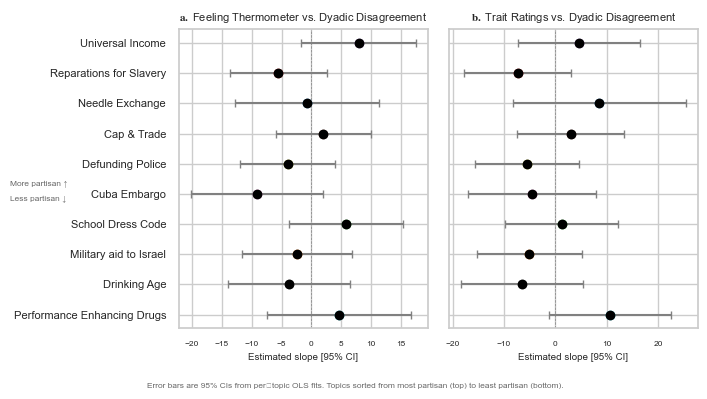

In [41]:

# Your short names mapping:
shortNames = {
    "capAndTrade": "Cap & Trade",
    "drinkingAge": "Drinking Age",
    "fundNeedleExchange": "Needle Exchange",
    "israelAid": "Military aid to Israel",
    "schoolDressCode": "School Dress Code",
    "slaveReparations": "Reparations for Slavery",
    "universalIncome": "Universal Income",
    "sportsPEDs": "Performance Enhancing Drugs",
    "cubaEmbargo": "Cuba Embargo",
    "policeDefundingDiscrimination": "Defunding Police",
}

# 1) Decide the order of topics by average polarization (low→high)
topic_order = (
    data
    .groupby("discussionTopic")["topic_polarization_scaled"]
    .mean()
    .sort_values()
    .index
    .tolist()
)

# 2) Run per‐topic univariate regressions
records = []
for dv, dv_label in [
    ("outpartyTemp_change", "Feeling Thermometer Change (°)"),
    ("trait_ratings_change_percent", "Trait Ratings Change (%)")
]:
    for topic in topic_order:
        df_sub = data[data.discussionTopic == topic].dropna(subset=[dv, "disagreement_scaled"])
        if len(df_sub) < 3:
            continue
        X = sm.add_constant(df_sub["disagreement_scaled"])
        y = df_sub[dv]
        m = sm.OLS(y, X).fit()
        slope = m.params["disagreement_scaled"]
        ci_low, ci_upp = m.conf_int().loc["disagreement_scaled"]
        records.append({
            "discussionTopic": topic,
            "DV": dv,
            "slope": slope,
            "ci_low": ci_low,
            "ci_upp": ci_upp,
        })

slopes_df = pd.DataFrame.from_records(records)

# 3) Plot
fig, axes = plt.subplots(1, 2, figsize=(7.2, 4), sharey=True)
group_colors = plt.get_cmap("tab10")

for ax, (dv, label, title) in zip(axes, [
    ("outpartyTemp_change", "a.", "Feeling Thermometer"),
    ("trait_ratings_change_percent", "b.",  "Trait Ratings")
]):
    df_plot = slopes_df[slopes_df["DV"] == dv]
    y_pos = np.arange(len(topic_order))

    # error bars
    ax.errorbar(
        df_plot["slope"],
        y_pos,
        xerr=np.vstack([
            df_plot["slope"] - df_plot["ci_low"],
            df_plot["ci_upp"] - df_plot["slope"],
        ]),
        fmt="o",
        color="black",
        ecolor="gray",
        capsize=3
    )

    # colored points
    for i, topic in enumerate(topic_order):
        row = df_plot[df_plot.discussionTopic == topic].iloc[0]
        c = data.loc[data.discussionTopic == topic, "color"].iloc[0]
        ax.plot(row["slope"], i, "o", color=c, markersize=6, alpha=0.8)

    ax.set_title(rf"$\mathbf{{{label}}}$ {title} vs. Dyadic Disagreement", fontsize=8)
    ax.set_xlabel("Estimated slope [95% CI]", fontsize=7)

    # human‐readable y‐labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels([shortNames[t] for t in topic_order], fontsize=8)
    ax.invert_yaxis()
    ax.axvline(0, color="gray", linestyle="--", linewidth=0.5)
    ax.tick_params(axis="x", labelsize=6)

# hide right‐side y‐labels
axes[1].tick_params(axis="y", labelleft=False)

# footnote
fig.text(
    0.5, 0.01,
    "Error bars are 95% CIs from per‐topic OLS fits. "
    "Topics sorted from most partisan (top) to least partisan (bottom).",
    ha="center", fontsize=6, color="dimgray"
)

# partisan indicator on left margin
fig.text(
    0.02, 0.5,
    "More partisan ↑\n\nLess partisan ↓",
    va="center", ha="left", fontsize=6, color="dimgray"
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig("fig_disagreement_by_topic.pdf", format="pdf")

In [42]:
!pip list --format=columns

Package                 Version
----------------------- -----------
appnope                 0.1.4
arviz                   0.21.0
asttokens               3.0.0
cachetools              5.5.2
cloudpickle             3.1.1
comm                    0.2.2
cons                    0.4.6
contourpy               1.3.2
cycler                  0.12.1
debugpy                 1.8.14
decorator               5.2.1
etuples                 0.3.9
executing               2.2.0
filelock                3.18.0
fonttools               4.57.0
graphviz                0.20.3
h5netcdf                1.6.1
h5py                    3.13.0
importlib_metadata      8.7.0
ipykernel               6.29.5
ipython                 9.1.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
joblib                  1.4.2
jupyter_client          8.6.3
jupyter_core            5.7.2
kiwisolver              1.4.8
logical-unification     0.4.6
markdown-it-py          3.0.0
matplotlib              3.10.1
matplotlib-inline     